In [7]:
import networkx as nx
import pickle
import random
import scipy
from scipy.sparse import tril, find
import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import igraph
from django.core.management import call_command

sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.tasks import *
import tmv_app
import tmv_app.utils.plotting as tplots
from tmv_app.utils.plotting import SquareCollection, CoordSquare

### Create groups of impacts, drivers and responses

In [2]:
run_id = 2927

In [8]:
#List of the title for agregated topic with the associated list of IDs from the topic model
Im_all = [
    ['Patients/health sys.', [213136, 213161, 213159, 213144]],
    ['All-cause mortality', [213125, 213177]],
    ['Respiratory', [213123, 213160, 213132, 213183, 213174]],
    ['Chronic', [213131, 213178, 213155]],
    ['Infectious disease',[213137, 213127, 213128, 213135, 213156, 213148, 213189, 213180, 213142]],
    ['WASH', [213143]],
    ['Food & nutrition', [213151, 213152]],
    ['Maternal/child', [213147,213162]],
    ['Mental health', [213172, 213175]],
    ['Occupational health', [213184]]
]

len(Im_all)

10

In [9]:
#list of lists with drivers -- now known as hazards
Dr_all = [
    ['General climate change', [213122]],
    ['General seasonality', [213154, 213146]],
    ['Flooding', [213167, 213149, 213133]],
    ['Precipitation variab.', [213186]],
    ['Drought', [213173, 213157, 213176]],
    ['Heat', [213140, 213166, 213141, 213182, 213171]],
    ['Emissions', [213130, 213150, 213124, 213153, 213165]]
]

len(Dr_all)

7

In [10]:
#List of list with responses/intervention options
Re_all = [
    ['Mitigation co-benefits', [213190, 213179]],
    ['Policy & practice', [213169]],
    ['Disaster risk reduction', [213126]],
    ['Community resilience', [213139]]
]
len(Re_all)

4

In [11]:
#List of list with mediating pathways
Me_all = [
    ['Geographic exposure', [213129, 213187, 213191, 213181]],
    ['Demographic vulnerability', [213188]],
    ['Social vulnerability', [213158]],
]
len(Me_all)

3

### Get topic scores

In [29]:
dts_wide = pd.DataFrame.from_dict(
    DocTopic.objects.filter(run_id=run_id).values('doc_id','topic_id','score')
)

dts_wide.dropna(subset=['doc_id'], inplace=True)

dts_wide = dts_wide.pivot(index="doc_id",columns="topic_id",values="score")

dts_wide.shape

(16050, 70)

In [30]:
impacts = pd.DataFrame()
#thresh = 0.015

for title, ids in Im_all:
    impacts[title] = dts_wide[ids].sum(axis=1)

#could also use y instead of 0 to return the scores above the threshold
#impacts = impacts.apply(lambda x: [0 if y <= thresh else 1 for y in x])    

print(impacts.shape)
impacts.head()

(16050, 10)


Patients/health sys.  All-cause mortality  Respiratory   Chronic  \
103.0               0.000000             0.009277     0.000000  0.000000   
562.0               0.065256             0.016809     0.009821  0.000024   
1061.0              0.000000             0.000000     0.012908  0.000000   
1285.0              0.009210             0.010156     0.020111  0.003979   
1672.0              0.094190             0.001745     0.010906  0.000621   

        Infectious disease  WASH  Food & nutrition  Maternal/child  \
103.0             0.005813   0.0          0.037914        0.000000   
562.0             0.013844   0.0          0.000000        0.000000   
1061.0            0.000000   0.0          0.000000        0.000000   
1285.0            0.015633   0.0          0.000000        0.000000   
1672.0            0.035253   0.0          0.001266        0.014238   

        Mental health  Occupational health  
103.0        0.000000             0.000000  
562.0        0.000000             0.000000  
1061.0       0.000000             0.006059  
1285.0       0.003256             0.000000  
1672.0       0.001271             0.000000

In [31]:
drivers = pd.DataFrame()
#thresh = 0.01

for title, ids in Dr_all:
    drivers[title] = dts_wide[ids].sum(axis=1)

#drivers = drivers.apply(lambda x: [0 if y <= thresh else 1 for y in x])    
print(drivers.shape)
drivers.head()

(16050, 7)


General climate change  General seasonality  Flooding  \
103.0                 0.000000             0.008028  0.000000   
562.0                 0.067808             0.000116  0.005612   
1061.0                0.000000             0.007688  0.000000   
1285.0                0.002073             0.024780  0.000000   
1672.0                0.032696             0.005140  0.040024   

        Precipitation variab.  Drought      Heat  Emissions  
103.0                     0.0  0.23172  0.000000   0.000179  
562.0                     0.0  0.00000  0.001507   0.011236  
1061.0                    0.0  0.00000  0.006329   0.233757  
1285.0                    0.0  0.00000  0.003969   0.063101  
1672.0                    0.0  0.00000  0.083214   0.000000

In [32]:
responses = pd.DataFrame()
#thresh = 0.01

for title, ids in Re_all:
    responses[title] = dts_wide[ids].sum(axis=1)

#drivers = drivers.apply(lambda x: [0 if y <= thresh else 1 for y in x])    
print(responses.shape)
responses.head()

(16050, 4)


Mitigation co-benefits  Policy & practice  Disaster risk reduction  \
103.0                 0.000000           0.004777                      0.0   
562.0                 0.038895           0.000000                      0.0   
1061.0                0.000000           0.000000                      0.0   
1285.0                0.000000           0.000000                      0.0   
1672.0                0.000000           0.000000                      0.0   

        Community resilience  
103.0               0.079174  
562.0               0.000000  
1061.0              0.000000  
1285.0              0.008716  
1672.0              0.007006

In [33]:
mediating = pd.DataFrame()
#thresh = 0.01

for title, ids in Me_all:
    mediating[title] = dts_wide[ids].sum(axis=1)

#drivers = drivers.apply(lambda x: [0 if y <= thresh else 1 for y in x])    
print(mediating.shape)
mediating.head()

(16050, 3)


Geographic exposure  Demographic vulnerability  Social vulnerability
103.0              0.018811                   0.000000              0.005004
562.0              0.000000                   0.000556              0.001700
1061.0             0.184152                   0.000000              0.000000
1285.0             0.000000                   0.022516              0.000000
1672.0             0.000134                   0.010383              0.009270

### Layout function b/c I couldn't keep typing everything again

In [34]:
def TitleAndSave(fig, ax, title, subtitle):
    ax.text(x=0.5, y=1.1, s=title, fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    ax.text(x=0.5, y=1.05, s=subtitle, fontsize=10, ha='center', va='bottom', transform=ax.transAxes)


    fig.tight_layout(rect=[0, 0, 1, 0.98])
    fig.savefig(f'heatmap_results/Final/{title}_{subtitle}.png')
    
    return fig, ax
    

### Heat map: impacts against drivers

In [121]:
m = np.zeros((impacts.shape[1], drivers.shape[1]), int)

df = pd.concat([impacts, drivers], axis=1)

thresh = 0.015

#Count how many documents meet both the impact and the driver threshold
for i, im_topic in enumerate(impacts):
    for j, dr_topic in enumerate(drivers):
        m[i,j] = len(
            df.loc[(df[im_topic] >= thresh) & (df[dr_topic] >= thresh)]
        )

print(df[
    (df[drivers.columns].max(axis=1)>thresh) &
    (df[impacts.columns].max(axis=1)>thresh)
].shape)
df.head()

(11570, 17)


Patients/health sys.  All-cause mortality  Respiratory   Chronic  \
103               0.000000             0.009277     0.000000  0.000000   
562               0.065256             0.016809     0.009821  0.000024   
1061              0.000000             0.000000     0.012908  0.000000   
1285              0.009210             0.010156     0.020111  0.003979   
1672              0.094190             0.001745     0.010906  0.000621   

      Infectious disease  WASH  Food & nutrition  Maternal/child  \
103             0.005813   0.0          0.037914        0.000000   
562             0.013844   0.0          0.000000        0.000000   
1061            0.000000   0.0          0.000000        0.000000   
1285            0.015633   0.0          0.000000        0.000000   
1672            0.035253   0.0          0.001266        0.014238   

      Mental health  Occupational health  General climate change  \
103        0.000000             0.000000                0.000000   
562        0.000000             0.000000                0.067808   
1061       0.000000             0.006059                0.000000   
1285       0.003256             0.000000                0.002073   
1672       0.001271             0.000000                0.032696   

      General seasonality  Flooding  Precipitation variab.  Drought      Heat  \
103              0.008028  0.000000                    0.0  0.23172  0.000000   
562              0.000116  0.005612                    0.0  0.00000  0.001507   
1061             0.007688  0.000000                    0.0  0.00000  0.006329   
1285             0.024780  0.000000                    0.0  0.00000  0.003969   
1672             0.005140  0.040024                    0.0  0.00000  0.083214   

      Emissions  
103    0.000179  
562    0.011236  
1061   0.233757  
1285   0.063101  
1672   0.000000

(<Figure size 1500x900 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ca6f3f780>)

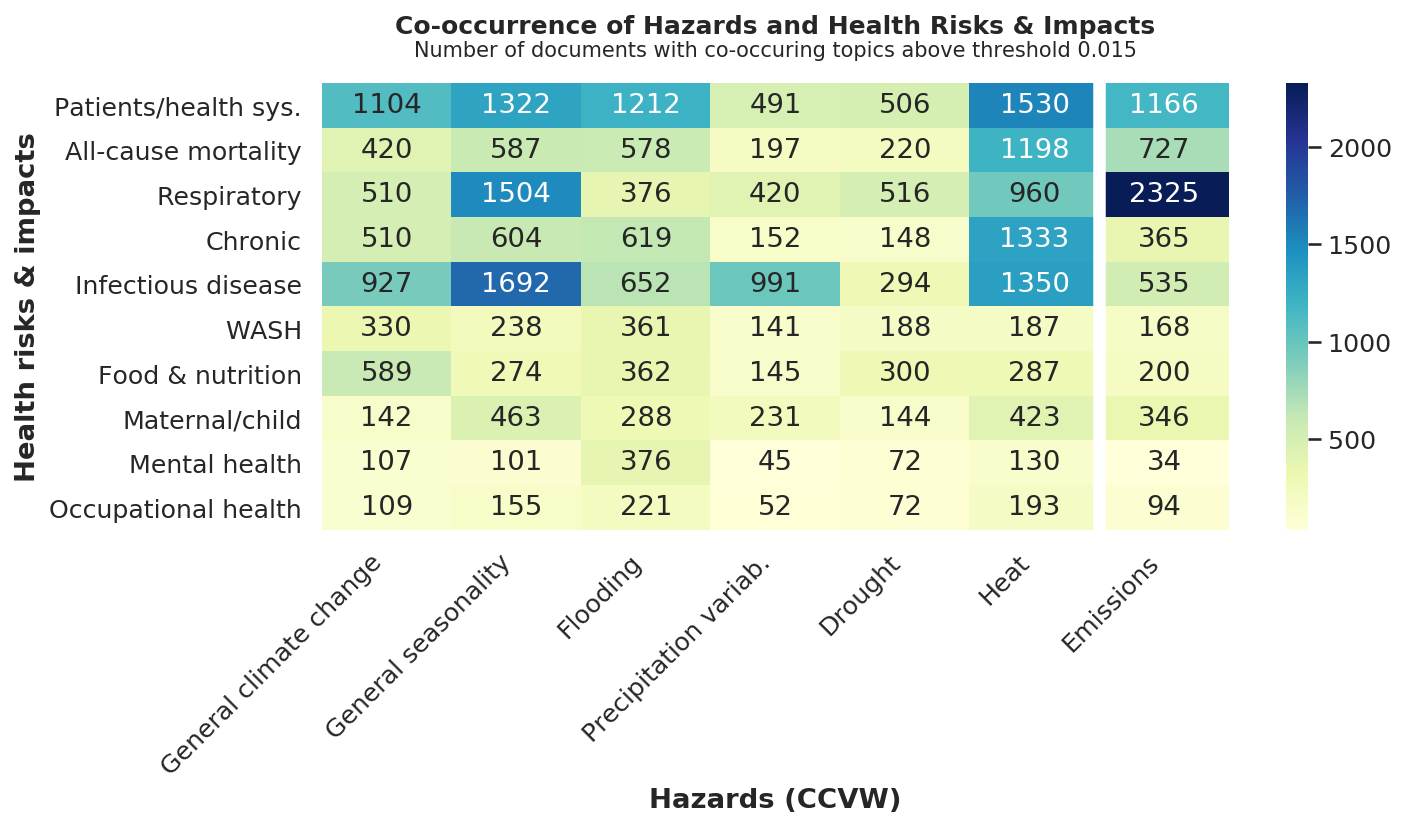

In [122]:
import seaborn as sns
from matplotlib.colors import LogNorm

yticks = impacts.columns.to_list()
xticks = drivers.columns.to_list()

sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(10,6),dpi=150)

ax.axvline(m.shape[1]-1, color='white', lw=6)

sns.heatmap(m, ax=ax, cmap="YlGnBu",annot=True, fmt="d")

ax.set_xticklabels(xticks, rotation=45, ha="right")
ax.set_yticklabels(yticks, rotation=0)

plt.xlabel('Hazards (CCVW)', weight = 'bold')
plt.ylabel('Health risks & impacts', weight = 'bold')

title = f'Co-occurrence of Hazards and Health Risks & Impacts'
subtitle = f"Number of documents with co-occuring topics above threshold {thresh}"

TitleAndSave(fig, ax, title, subtitle)

In [94]:
import pickle

with open("data/impact_driver_map.pickle", "wb") as f:
    pickle.dump([m,xticks,yticks], f)
df.reset_index().to_csv("data/impact_driver_map.csv",index=False)

#### Normalising rows/columns to percentages

(<Figure size 1500x900 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ca4c47f28>)

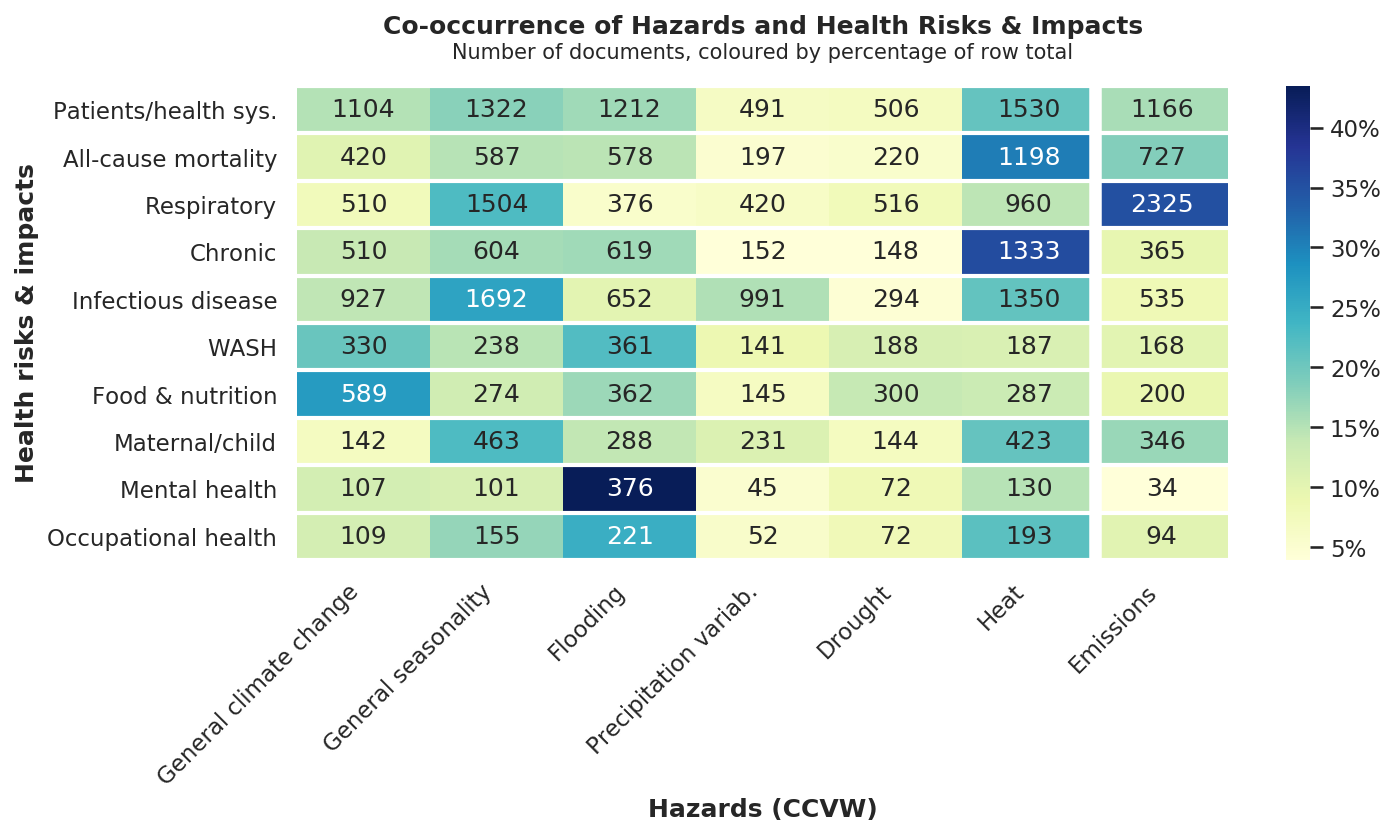

In [135]:
m_rows = (100*m)/m.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize = (10,6), dpi=150)

sns.heatmap(m_rows, ax=ax, cmap="YlGnBu",annot=m, fmt='d', cbar_kws={'format': '%.0f%%'})

#add horizontal lines
for i in range(m_rows.shape[0]+1):
    ax.axhline(i, color='white', lw=2)
    
ax.axvline(m.shape[1]-1, color='white', lw=6)

#for t in ax.texts: t.set_text(t.get_text() + " %")
#sns.plt.ticklabel_format(style='plain')

yticks = impacts.columns.to_list()
xticks = drivers.columns.to_list()

ax.set_xticklabels(xticks, rotation=45, ha="right")
ax.set_yticklabels(yticks, rotation=0)

plt.xlabel('Hazards Hazards (CCVW)', weight = 'bold')
plt.ylabel('Months', weight = 'bold')

plt.xlabel('Hazards (CCVW)', weight = 'bold')
plt.ylabel('Health risks & impacts', weight = 'bold')

title = 'Co-occurrence of Hazards and Health Risks & Impacts'
subtitle = f"Number of documents, coloured by percentage of row total"

TitleAndSave(fig, ax, title, subtitle)

(<Figure size 1500x900 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ca5707da0>)

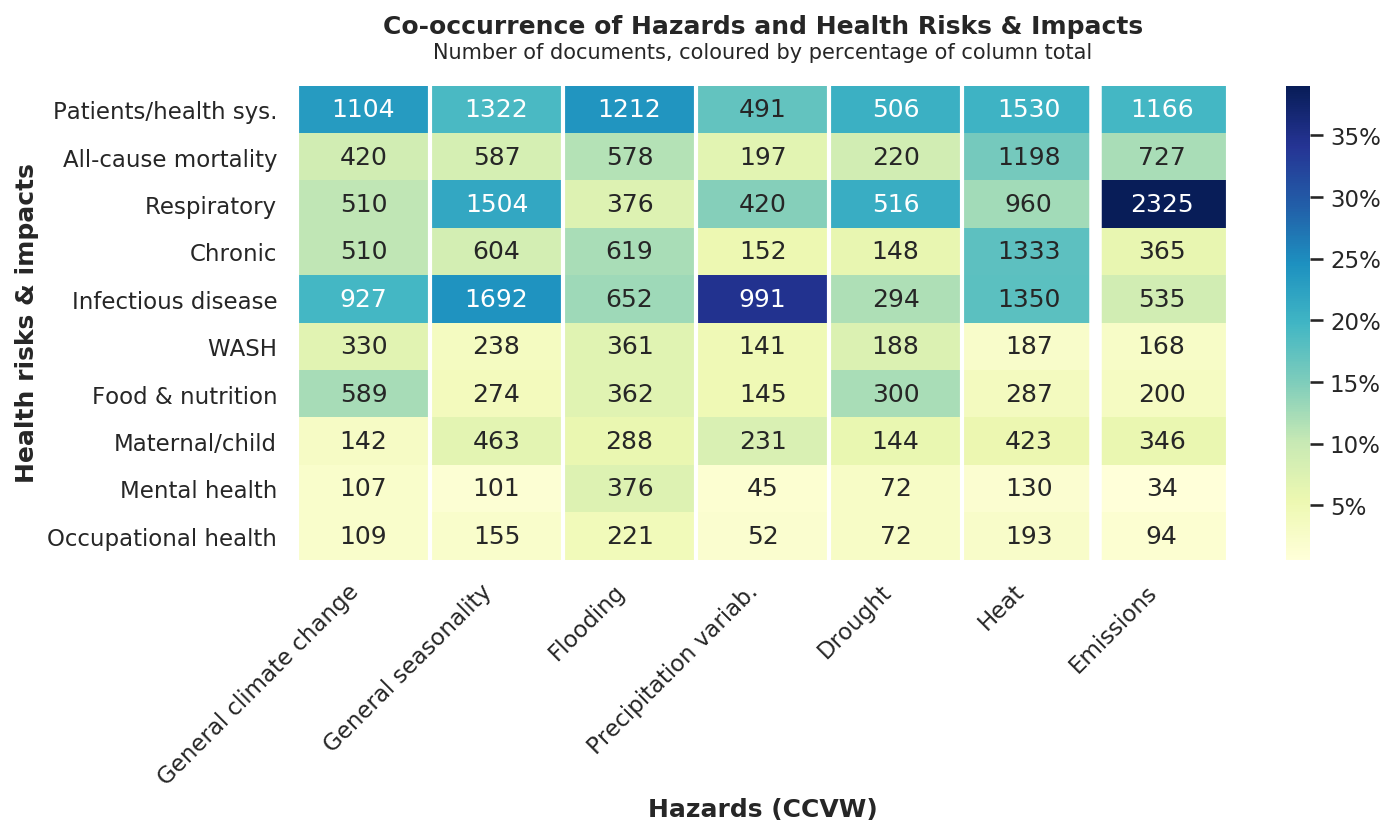

In [123]:
sns.set(font_scale=1)
m_cols = (100*m)/m.sum(axis=0, keepdims=True)

fig, ax = plt.subplots(figsize = (10,6), dpi=150)

sns.heatmap(m_cols, ax=ax, cmap="YlGnBu",annot=m, fmt='d', cbar_kws={'format': '%.0f%%'})

#add vertical lines
for i in range(m_cols.shape[1]+1):
    ax.axvline(i, color='white', lw=2)
    
ax.axvline(m.shape[1]-1, color='white', lw=6)
    
#for t in ax.texts: t.set_text(t.get_text() + " %")
#sns.plt.ticklabel_format(style='plain')

ax.set_xticklabels(xticks, rotation=45, ha="right")
ax.set_yticklabels(yticks, rotation=0)
#fig.suptitle('Co-occurrence of Hazard and Health Impacts', fontsize=10, fontweight='bold', x=0.43)
#ax.set_title("Number of documents, coloured by percentage of column total", fontsize=8)

plt.xlabel('Hazards (CCVW)', weight = 'bold')
plt.ylabel('Health risks & impacts', weight = 'bold')

title = 'Co-occurrence of Hazards and Health Risks & Impacts'
subtitle = "Number of documents, coloured by percentage of column total"
TitleAndSave(fig, ax, title, subtitle)


Text(0.5, 0.98, 'Percentage of documents per column above threshold 0.15 for aggregated drivers and impacts')

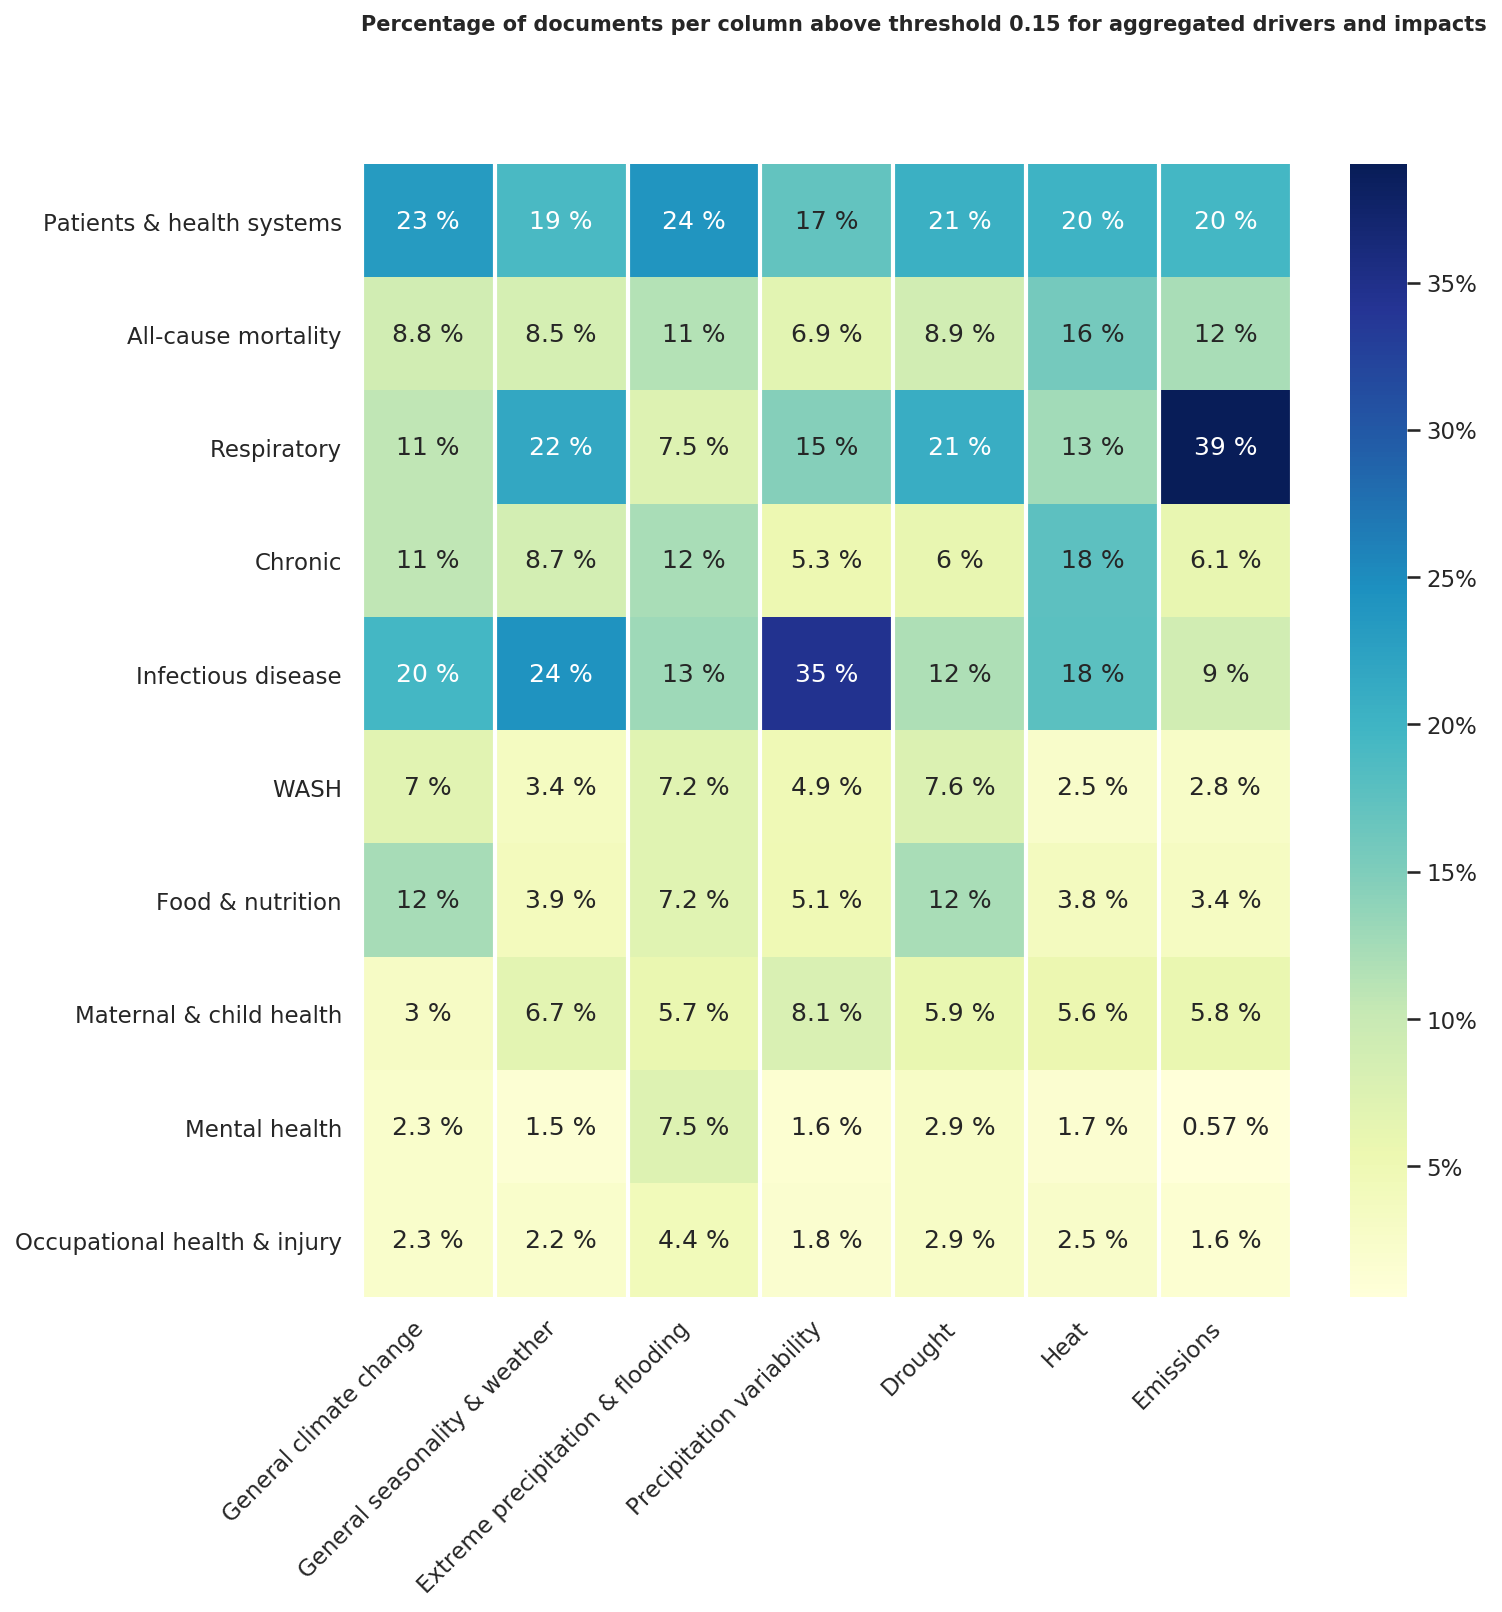

In [97]:
m_cols = 

fig, ax = plt.subplots(figsize = (10,10), dpi=150)

sns.heatmap(m_cols, ax=ax, cmap="YlGnBu",annot=True, cbar_kws={'format': '%.0f%%'})

#add vertical lines
for i in range(m_cols.shape[1]+1):
    ax.axvline(i, color='white', lw=2)
    
for t in ax.texts: t.set_text(t.get_text() + " %")

ax.set_xticklabels(xticks, rotation=45, ha="right")
ax.set_yticklabels(yticks, rotation=0)
fig.suptitle("Percentage of documents per column above threshold 0.15 for aggregated drivers and impacts", fontsize=10, fontweight='bold')

## Impacts and country categories

In [35]:
df_places = pd.read_csv('data/df_places.csv')
df_places.head()

id  label  prediction      admin1       lat        lon country_code3  \
0  2418301    NaN    0.389674       Texas  30.10361  -97.31201           USA   
1  2418301    NaN    0.389674       Texas  31.25044  -99.25061           USA   
2  3367070    NaN    0.647456      Nevada  39.25021 -116.75119           USA   
3  3427990    NaN    0.469134   Louisiana  29.95465  -90.07507           USA   
4  3370522    NaN    0.788942  New Jersey  40.16706  -74.49987           USA   

   geonameid      place_name feature_class  ... Population_2019  \
0    4672581  Bastrop County             A  ...     329,064,917   
1    4736286           Texas             A  ...     329,064,917   
2    5509151          Nevada             A  ...     329,064,917   
3    4335045     New Orleans             P  ...     329,064,917   
4    5101760      New Jersey             A  ...     329,064,917   

   Annex I or II SIDS DFID priority  Income Unnamed: 14 Unnamed: 15  \
0        Annex I  NaN             0    High         NaN         NaN   
1        Annex I  NaN             0    High         NaN         NaN   
2        Annex I  NaN             0    High         NaN         NaN   
3        Annex I  NaN             0    High         NaN         NaN   
4        Annex I  NaN             0    High         NaN         NaN   

  Unnamed: 16 Unnamed: 17  Unnamed: 18  
0         NaN         NaN          NaN  
1         NaN         NaN          NaN  
2         NaN         NaN          NaN  
3         NaN         NaN          NaN  
4         NaN         NaN          NaN  

[5 rows x 35 columns]

In [36]:
country_category = "Income"

#renaming them as the default is to give them by alphabetical order
df_places.loc[df_places["Income"]=="High", "Income_alph"] = "A - High"
df_places.loc[df_places["Income"]=="Upper-middle", "Income_alph"] = "B - Upper-middle"
df_places.loc[df_places["Income"]=="Lower-middle", "Income_alph"] = "C - Lower-middle"
df_places.loc[df_places["Income"]=="Low", "Income_alph"] = "D - Low"

#topic_places = df_places.merge(impacts.reset_index()) #Don't know why it stopped working, but now it's the below
topic_places = pd.merge(df_places, impacts.reset_index(), how = 'left', left_on = 'id', right_on = 'index')

c = np.zeros((impacts.shape[1], len(topic_places["Income_alph"].unique())), int)

thresh = 0.015

#Count how many documents meet the threshold per country group
for j, (name, group) in enumerate(topic_places.sort_values("Income_alph").groupby("Income_alph")):
    for i, im_topic in enumerate(impacts):
        c[i,j] = len(
            group.loc[(group[im_topic] >= thresh),"id"].unique()
        )

print(len(topic_places[
    (topic_places[impacts.columns].max(axis=1)>thresh)
]['doc_id'].unique()))


6978


In [37]:
topic_places['Income_alph'].head(20)

0     A - High
1     A - High
2     A - High
3     A - High
4     A - High
5     A - High
6     A - High
7     A - High
8     A - High
9     A - High
10    A - High
11    A - High
12    A - High
13    A - High
14    A - High
15    A - High
16    A - High
17    A - High
18    A - High
19    A - High
Name: Income_alph, dtype: object

In [38]:
df_places.rename(columns={
    "Patients & health systems": "Patients/health sys.",
    "Maternal & child health": "Maternal/child",
    "Occupational health & injury": "Occupational health"
})

id  label  prediction      admin1       lat        lon  \
0      2418301    NaN    0.389674       Texas  30.10361  -97.31201   
1      2418301    NaN    0.389674       Texas  31.25044  -99.25061   
2      3367070    NaN    0.647456      Nevada  39.25021 -116.75119   
3      3427990    NaN    0.469134   Louisiana  29.95465  -90.07507   
4      3370522    NaN    0.788942  New Jersey  40.16706  -74.49987   
...        ...    ...         ...         ...       ...        ...   
15909  2152506    1.0    0.299341         NaN  19.50000  -80.66667   
15910  2365241    NaN    0.709247         NaN -29.50000   28.25000   
15911  3742573    NaN    0.417820         NaN -29.50000   28.25000   
15912   172150    NaN    0.461841         NaN  13.88333  -60.96667   
15913  3461923    1.0    0.298266         NaN  -1.00000   15.50000   

      country_code3  geonameid             place_name feature_class  ...  \
0               USA    4672581         Bastrop County             A  ...   
1               USA    4736286                  Texas             A  ...   
2               USA    5509151                 Nevada             A  ...   
3               USA    4335045            New Orleans             P  ...   
4               USA    5101760             New Jersey             A  ...   
...             ...        ...                    ...           ...  ...   
15909           CYM    3580718         Cayman Islands             A  ...   
15910           LSO     932692     Kingdom of Lesotho             A  ...   
15911           LSO     932692     Kingdom of Lesotho             A  ...   
15912           LCA    3576468            Saint Lucia             A  ...   
15913           COG    2260494  Republic of the Congo             A  ...   

      Annex I or II       SIDS DFID priority        Income  Unnamed: 14  \
0           Annex I        NaN             0          High          NaN   
1           Annex I        NaN             0          High          NaN   
2           Annex I        NaN             0          High          NaN   
3           Annex I        NaN             0          High          NaN   
4           Annex I        NaN             0          High          NaN   
...             ...        ...           ...           ...          ...   
15909   Non-Annex I        NaN             0          High          NaN   
15910   Non-Annex I        NaN             0  Lower-middle          NaN   
15911   Non-Annex I        NaN             0  Lower-middle          NaN   
15912   Non-Annex I  Caribbean             0  Upper-middle          NaN   
15913   Non-Annex I        NaN             0  Lower-middle          NaN   

      Unnamed: 15 Unnamed: 16 Unnamed: 17 Unnamed: 18       Income_alph  
0             NaN         NaN         NaN         NaN          A - High  
1             NaN         NaN         NaN         NaN          A - High  
2             NaN         NaN         NaN         NaN          A - High  
3             NaN         NaN         NaN         NaN          A - High  
4             NaN         NaN         NaN         NaN          A - High  
...           ...         ...         ...         ...               ...  
15909         NaN         NaN         NaN         NaN          A - High  
15910         NaN         NaN         NaN         NaN  C - Lower-middle  
15911         NaN         NaN         NaN         NaN  C - Lower-middle  
15912         NaN         NaN         NaN         NaN  B - Upper-middle  
15913         NaN         NaN         NaN         NaN  C - Lower-middle  

[15914 rows x 36 columns]

(<Figure size 1200x900 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f932b90b940>)

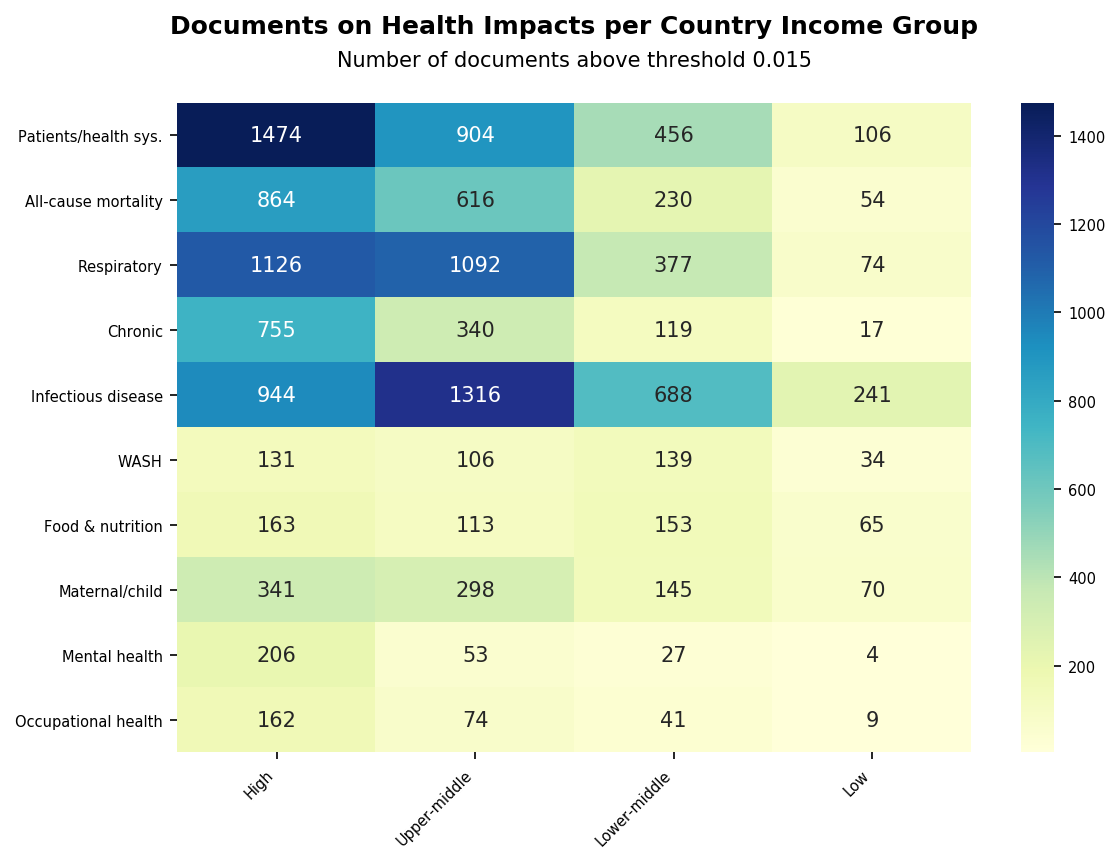

In [39]:
import seaborn as sns
from matplotlib.colors import LogNorm

yticks = impacts.columns.to_list()
xticks = [x.split(" - ")[1] for x in topic_places.sort_values("Income_alph")["Income_alph"].unique()]

fig, ax = plt.subplots(figsize = (8,6), dpi=150)

sns.heatmap(c, ax=ax, cmap="YlGnBu",annot=True, fmt="d")

ax.set_xticklabels(xticks, rotation=45, ha="right")
ax.set_yticklabels(yticks, rotation=0)

title = f"Documents on Health Impacts per Country Income Group"
subtitle = f"Number of documents above threshold {thresh}"
TitleAndSave(fig, ax, title, subtitle)

(<Figure size 1200x900 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f93307f2e48>)

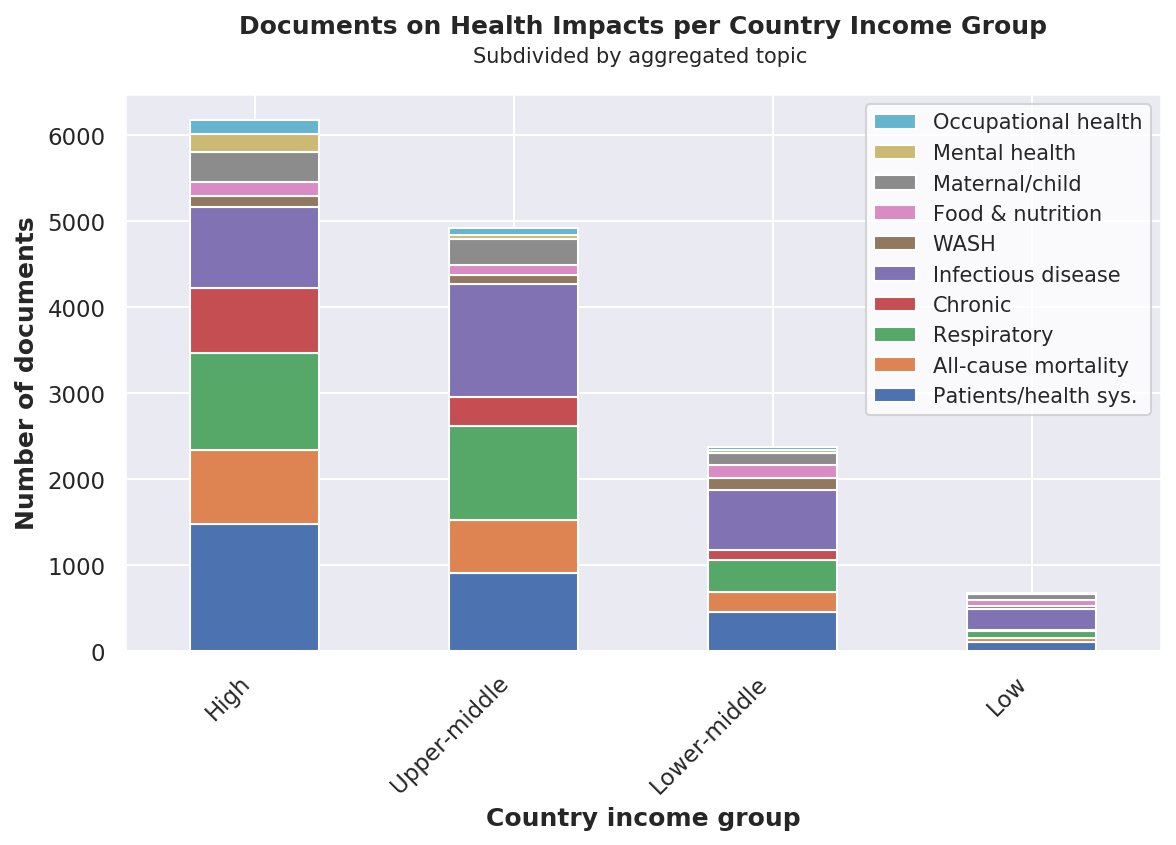

In [54]:
#now as a stacked bar graph
yticks = impacts.columns.to_list()
xticks = [x.split(" - ")[1] for x in topic_places.sort_values("Income_alph")["Income_alph"].unique()]

cdf = pd.DataFrame(c, columns = xticks, index = yticks)

import seaborn as sns
sns.set()

#plot
fig, ax = plt.subplots(figsize = (8,6), dpi=150)
cdf.T.plot(kind='bar', stacked=True, ax=ax)

ax.set_xticklabels(xticks, rotation=45, ha="right")

plt.xlabel('Country income group', weight = 'bold')
plt.ylabel('Number of documents', weight = 'bold')

#reverse order of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper right',
         facecolor = 'white', fontsize=10)

title = f"Documents on Health Impacts per Country Income Group"
subtitle = f"Subdivided by aggregated topic "
TitleAndSave(fig, ax, title, subtitle)

(<Figure size 1200x900 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9330527e10>)

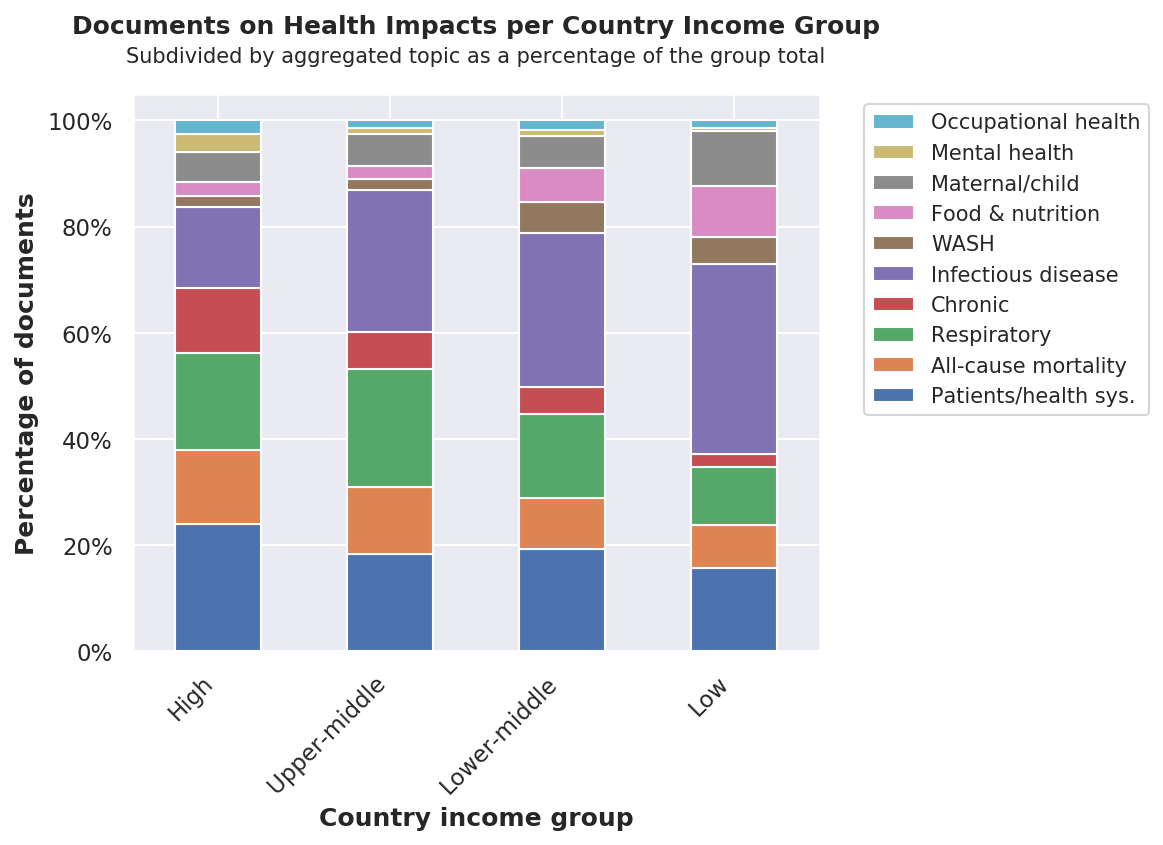

In [173]:
#Same, but as percentages
yticks = impacts.columns.to_list()
xticks = [x.split(" - ")[1] for x in topic_places.sort_values("Income_alph")["Income_alph"].unique()]

c_col = (100*c)/c.sum(axis=0, keepdims=True)
cdf_col = pd.DataFrame(c_col, columns = xticks, index = yticks)

import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

#plot
fig, ax = plt.subplots(figsize = (8,6), dpi=150)
cdf_col.T.plot(kind='bar', stacked=True, ax=ax)

ax.set_xticklabels(xticks, rotation=45, ha="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.xlabel('Country income group', weight = 'bold')
plt.ylabel('Percentage of documents', weight = 'bold')

#reverse order of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1), loc='upper left',
         facecolor = 'white', fontsize=10)

title = f"Documents on Health Impacts per Country Income Group"
subtitle = f"Subdivided by aggregated topic as a percentage of the group total"
TitleAndSave(fig, ax, title, subtitle)

In [168]:
c_col = (100*c)/c.sum(axis=0, keepdims=True)
c_col

array([[23.90528706, 18.40390879, 19.2       , 15.72700297],
       [14.01232566, 12.54071661,  9.68421053,  8.01186944],
       [18.26143367, 22.23127036, 15.87368421, 10.97922849],
       [12.24456698,  6.9218241 ,  5.01052632,  2.52225519],
       [15.30976322, 26.79153094, 28.96842105, 35.75667656],
       [ 2.12455401,  2.15798046,  5.85263158,  5.04451039],
       [ 2.64352903,  2.3004886 ,  6.44210526,  9.64391691],
       [ 5.5303276 ,  6.06677524,  6.10526316, 10.38575668],
       [ 3.34090172,  1.07899023,  1.13684211,  0.59347181],
       [ 2.62731106,  1.50651466,  1.72631579,  1.33531157]])

In [42]:
yticks = impacts.columns.to_list()
xticks = [x.split(" - ")[1] for x in topic_places.sort_values("Income_alph")["Income_alph"].unique()]

cdf = pd.DataFrame(c, columns = xticks, index = yticks)

cdf.head()

High  Upper-middle  Lower-middle  Low
Patients/health sys.  1474           904           456  106
All-cause mortality    864           616           230   54
Respiratory           1126          1092           377   74
Chronic                755           340           119   17
Infectious disease     944          1316           688  241

(<Figure size 1200x900 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ca4f40c18>)

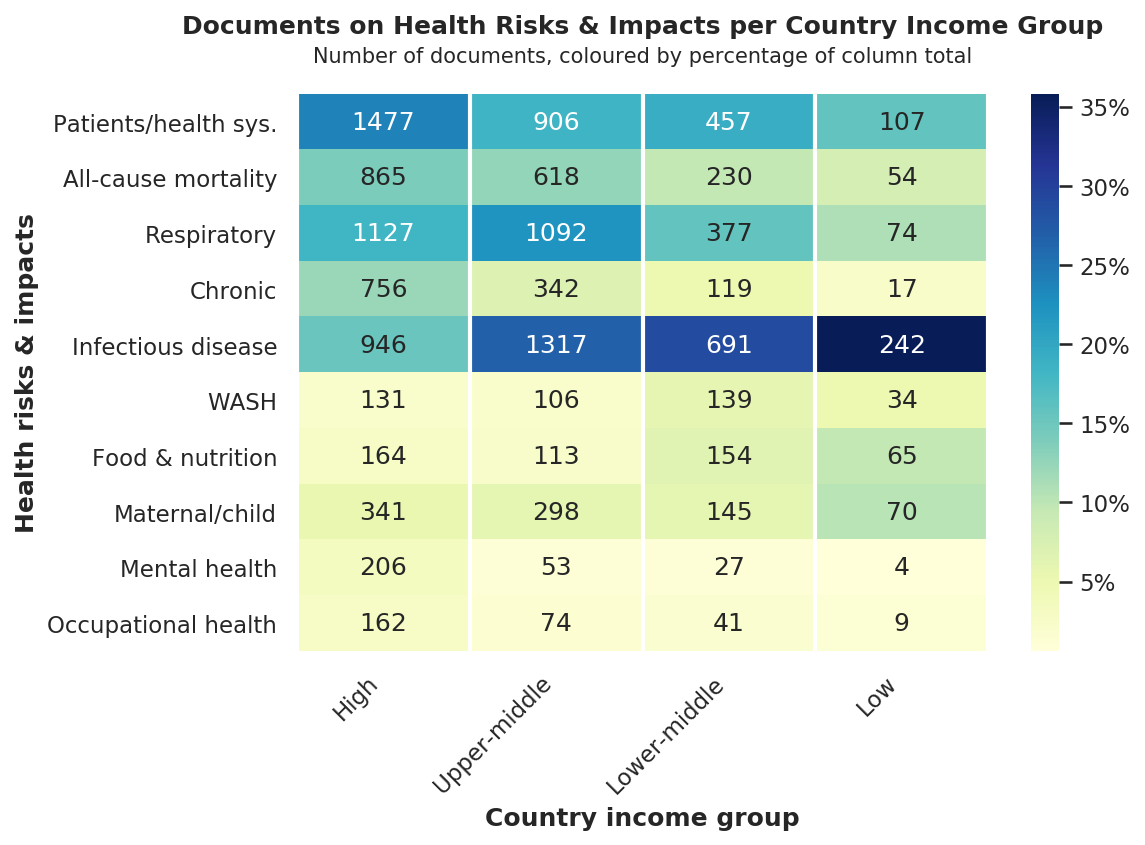

In [131]:
c_cols = (100*c)/c.sum(axis=0, keepdims=True)
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize = (8,6), dpi=150)

sns.heatmap(c_cols, ax=ax, cmap="YlGnBu",annot=c, fmt='d', cbar_kws={'format': '%.0f%%'})

#add vertical lines
for i in range(c_cols.shape[1]+1):
    ax.axvline(i, color='white', lw=2)

yticks = impacts.columns.to_list()
xticks = [x.split(" - ")[1] for x in topic_places.sort_values("Income_alph")["Income_alph"].unique()]
    
#for t in ax.texts: t.set_text(t.get_text() + " %")
#sns.plt.ticklabel_format(style='plain')

ax.set_xticklabels(xticks, rotation=45, ha="right")
ax.set_yticklabels(yticks, rotation=0)

plt.xlabel('Country income group', weight = 'bold')
plt.ylabel('Health risks & impacts', weight = 'bold')

title = 'Documents on Health Risks & Impacts per Country Income Group'
subtitle = "Number of documents, coloured by percentage of column total"
TitleAndSave(fig, ax, title, subtitle)


### Heat map: impacts against responses

In [132]:
n = np.zeros((impacts.shape[1], responses.shape[1]), int)

df = pd.concat([impacts, responses], axis=1)

thresh = 0.015

#Count how many documents meet both the impact and the driver threshold
for i, im_topic in enumerate(impacts):
    for j, re_topic in enumerate(responses):
        n[i,j] = len(
            df.loc[(df[im_topic] >= thresh) & (df[re_topic] >= thresh)]
        )

n

array([[847, 520, 526, 660],
       [565, 182, 183,  99],
       [727,  95,  50, 136],
       [517, 296,  79, 149],
       [533, 216, 160, 257],
       [218, 180,  94, 162],
       [374, 350, 124, 276],
       [105,  45, 129, 108],
       [ 42,  48, 264, 197],
       [ 94,  53, 104,  63]])

(<Figure size 1200x900 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ca4ecaa58>)

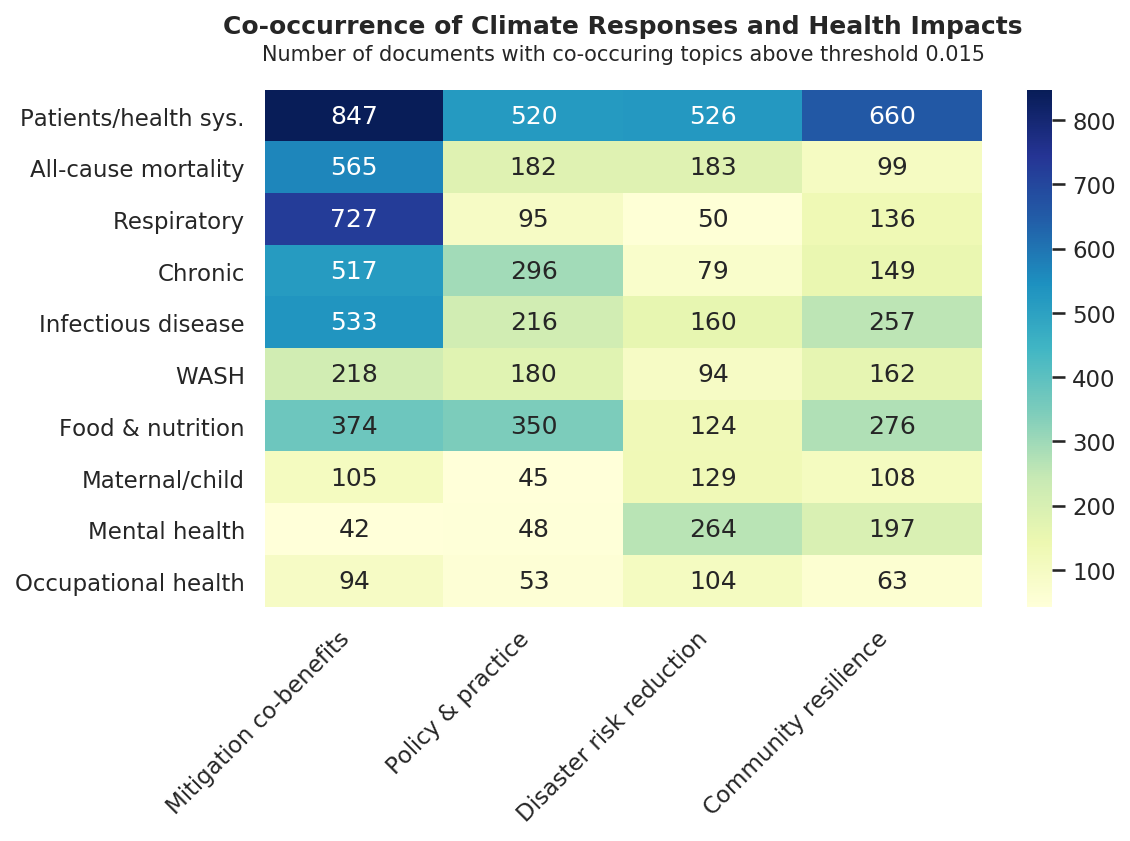

In [133]:
import seaborn as sns
from matplotlib.colors import LogNorm

yticks = impacts.columns.to_list()
xticks = responses.columns.to_list()

fig, ax = plt.subplots(figsize = (8,6), dpi=150)

sns.heatmap(n, ax=ax, cmap="YlGnBu",annot=True, fmt="d")

ax.set_xticklabels(xticks, rotation=45, ha="right")
ax.set_yticklabels(yticks, rotation=0)

title = 'Co-occurrence of Climate Responses and Health Impacts'
subtitle = f"Number of documents with co-occuring topics above threshold {thresh}"
TitleAndSave(fig, ax, title, subtitle)

#### Normalising rows/columns to percentages

(<Figure size 1600x1200 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ca4d362e8>)

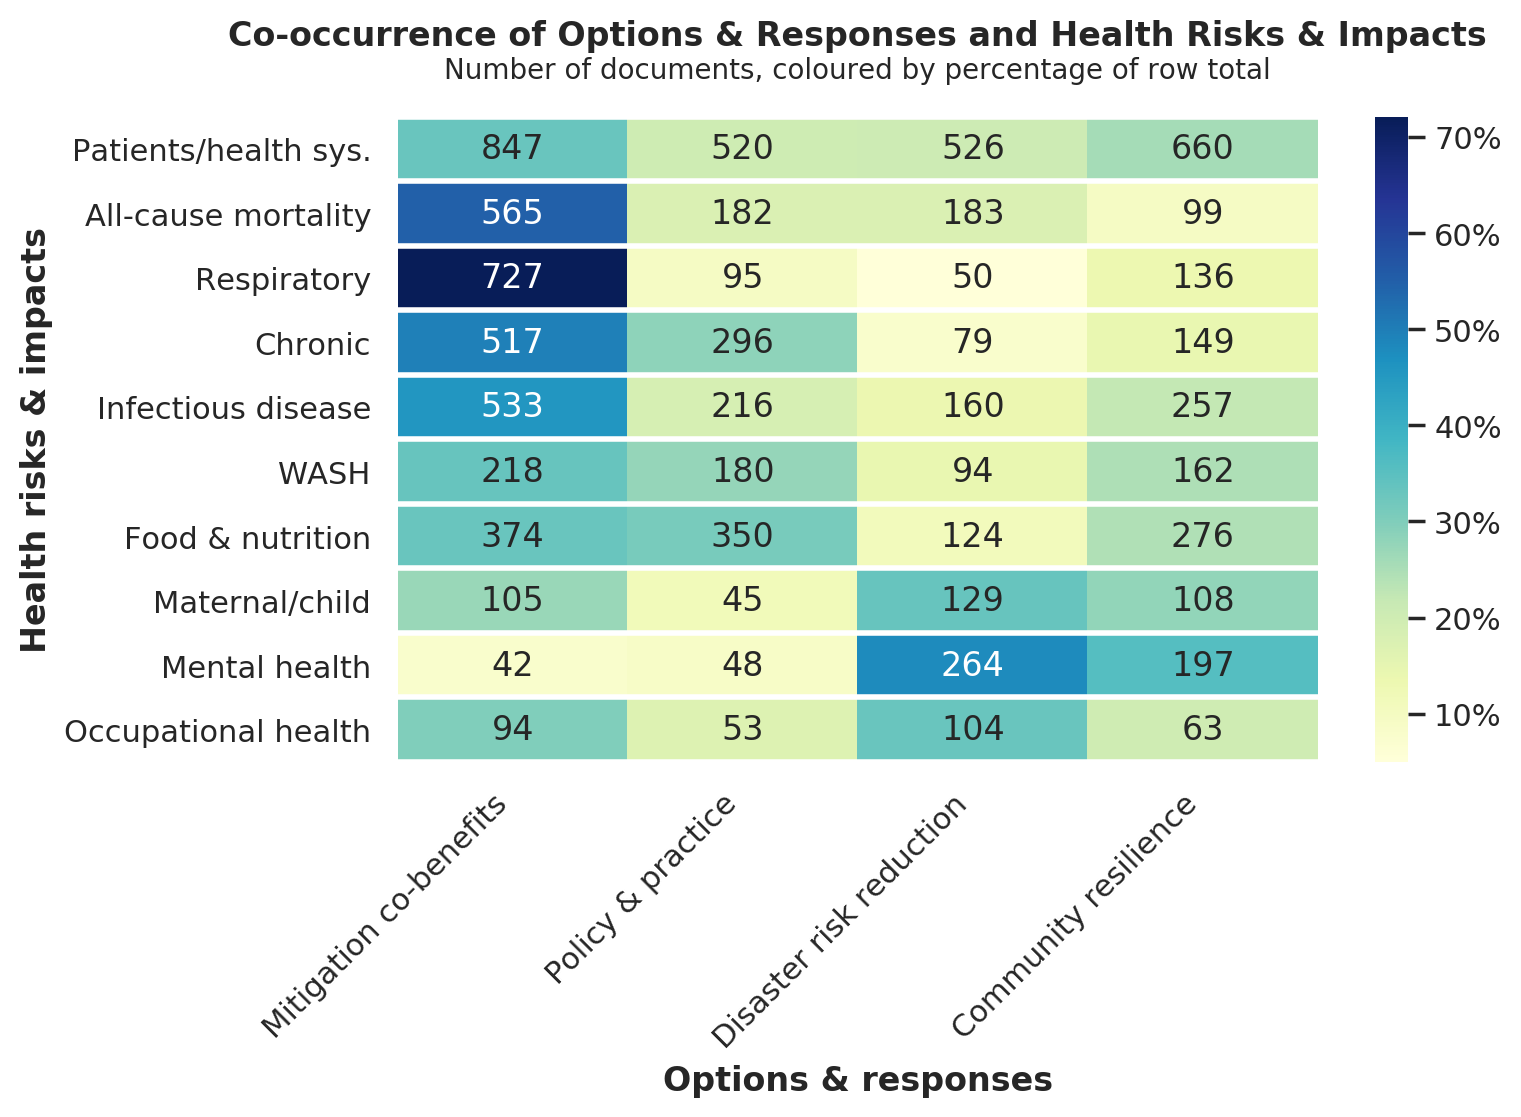

In [134]:
import matplotlib as mpl

mpl.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "black"})

sns.set(font_scale=1)
n_rows = (100*n)/n.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize = (8,6), dpi=200)

sns.heatmap(n_rows, ax=ax, cmap="YlGnBu",annot=n, fmt='d', cbar_kws={'format': '%.0f%%'})

#add horizontal lines
for i in range(n_rows.shape[0]+1):
    ax.axhline(i, color='white', lw=2)
    
#for t in ax.texts: t.set_text(t.get_text() + " %")
#sns.plt.ticklabel_format(style='plain')

ax.set_xticklabels(xticks, rotation=45, ha="right")
ax.set_yticklabels(yticks, rotation=0)

plt.xlabel('Options & responses', weight = 'bold')
plt.ylabel('Health risks & impacts', weight = 'bold')

title = 'Co-occurrence of Options & Responses and Health Risks & Impacts'
subtitle = "Number of documents, coloured by percentage of row total"
TitleAndSave(fig, ax, title, subtitle)

(<Figure size 1200x900 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f45d47f5f60>)

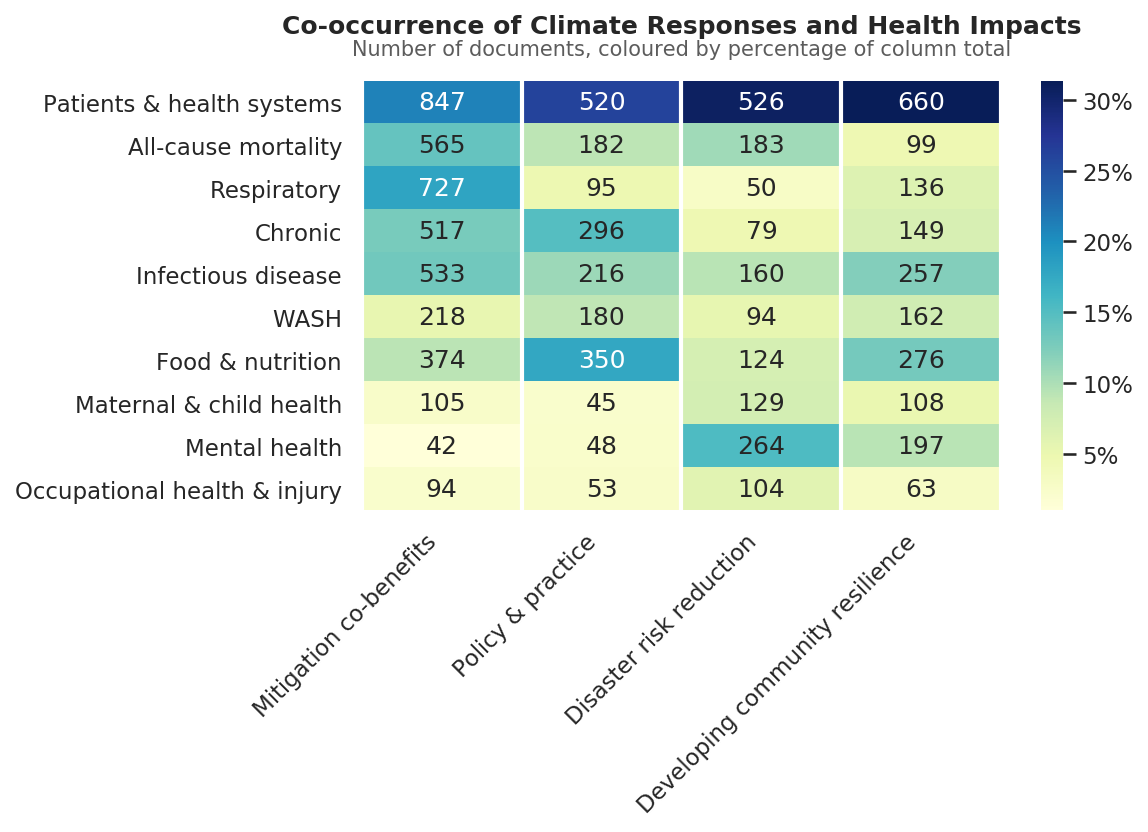

In [40]:
n_cols = (100*n)/n.sum(axis=0, keepdims=True)

fig, ax = plt.subplots(figsize = (8,6), dpi=150)

sns.heatmap(n_cols, ax=ax, cmap="YlGnBu",annot=n, fmt='d', cbar_kws={'format': '%.0f%%'})

#add vertical lines
for i in range(n_cols.shape[1]+1):
    ax.axvline(i, color='white', lw=2)
    
#for t in ax.texts: t.set_text(t.get_text() + " %")
#sns.plt.ticklabel_format(style='plain')

ax.set_xticklabels(xticks, rotation=45, ha="right")
ax.set_yticklabels(yticks, rotation=0)
title = 'Co-occurrence of Climate Responses and Health Impacts'
subtitle = "Number of documents, coloured by percentage of column total"
TitleAndSave(fig, ax, title, subtitle)

### Heat map of mediating pathways

In [136]:
o = np.zeros((impacts.shape[1], mediating.shape[1]), int)

df = pd.concat([impacts, mediating], axis=1)

thresh = 0.015

#Count how many documents meet both the impact and the driver threshold
for i, im_topic in enumerate(impacts):
    for j, me_topic in enumerate(mediating):
        o[i,j] = len(
            df.loc[(df[im_topic] >= thresh) & (df[me_topic] >= thresh)]
        )

o

array([[1285, 1055,  529],
       [ 652,  446,  249],
       [1398,  577,  104],
       [ 881,  325,  306],
       [1121,  796,  236],
       [ 408,  153,  172],
       [ 489,  175,  268],
       [ 449,  504,  114],
       [ 133,  278,   94],
       [ 197,  148,   76]])

(<Figure size 1050x1050 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ca4af5d30>)

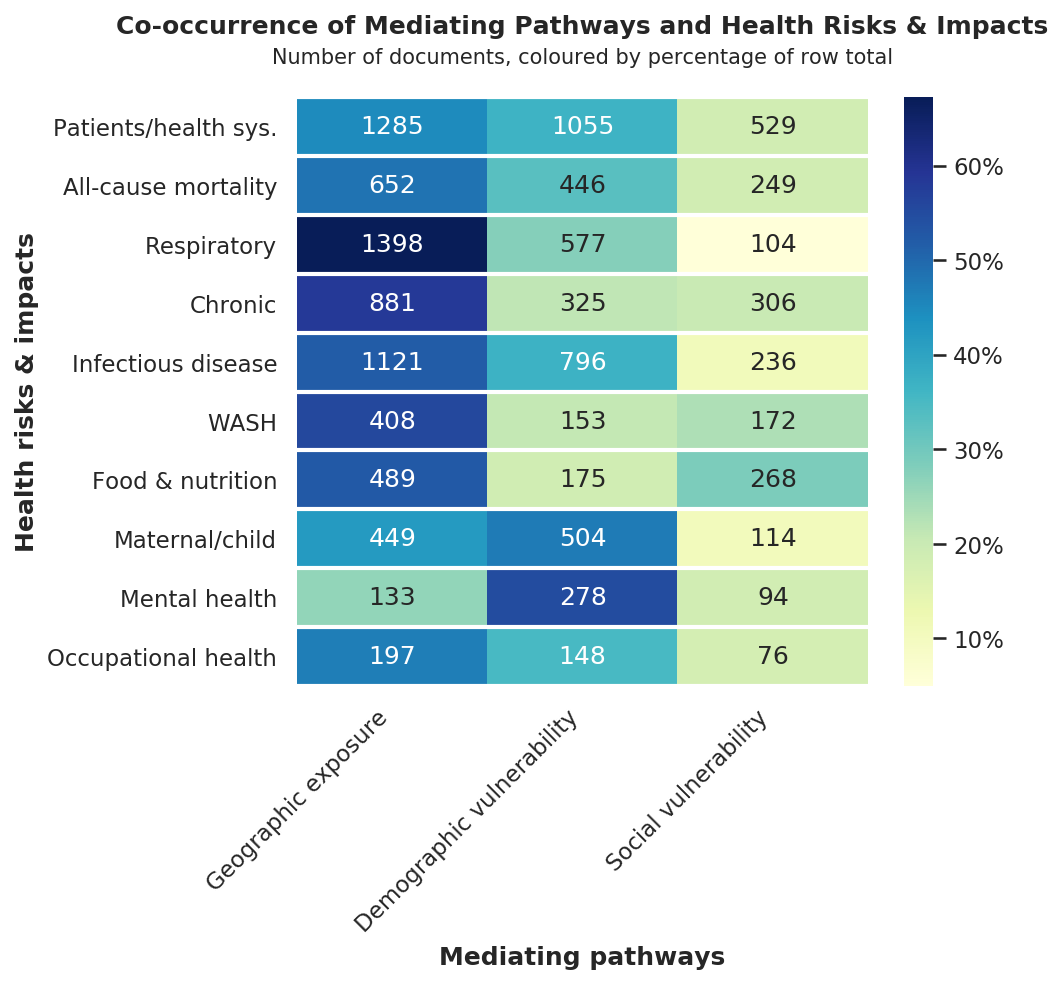

In [137]:
o_rows = (100*o)/o.sum(axis=1, keepdims=True)

#sns.set(font_scale=1)

fig, ax = plt.subplots(figsize =  (7,7), dpi=150)

yticks = impacts.columns.to_list()
xticks = mediating.columns.to_list()

sns.heatmap(o_rows, ax=ax, cmap="YlGnBu",annot=o, fmt='d', cbar_kws={'format': '%.0f%%'})

#add horizontal lines
for i in range(o_rows.shape[0]+1):
    ax.axhline(i, color='white', lw=2)
    
#for t in ax.texts: t.set_text(t.get_text() + " %")
#sns.plt.ticklabel_format(style='plain')

ax.set_xticklabels(xticks, rotation=45, ha="right")
ax.set_yticklabels(yticks, rotation=0)

plt.xlabel('Mediating pathways', weight = 'bold')
plt.ylabel('Health risks & impacts', weight = 'bold')

title = 'Co-occurrence of Mediating Pathways and Health Risks & Impacts'
subtitle = "Number of documents, coloured by percentage of row total"

TitleAndSave(fig, ax, title, subtitle)

(<Figure size 1050x1050 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f45d4648c18>)

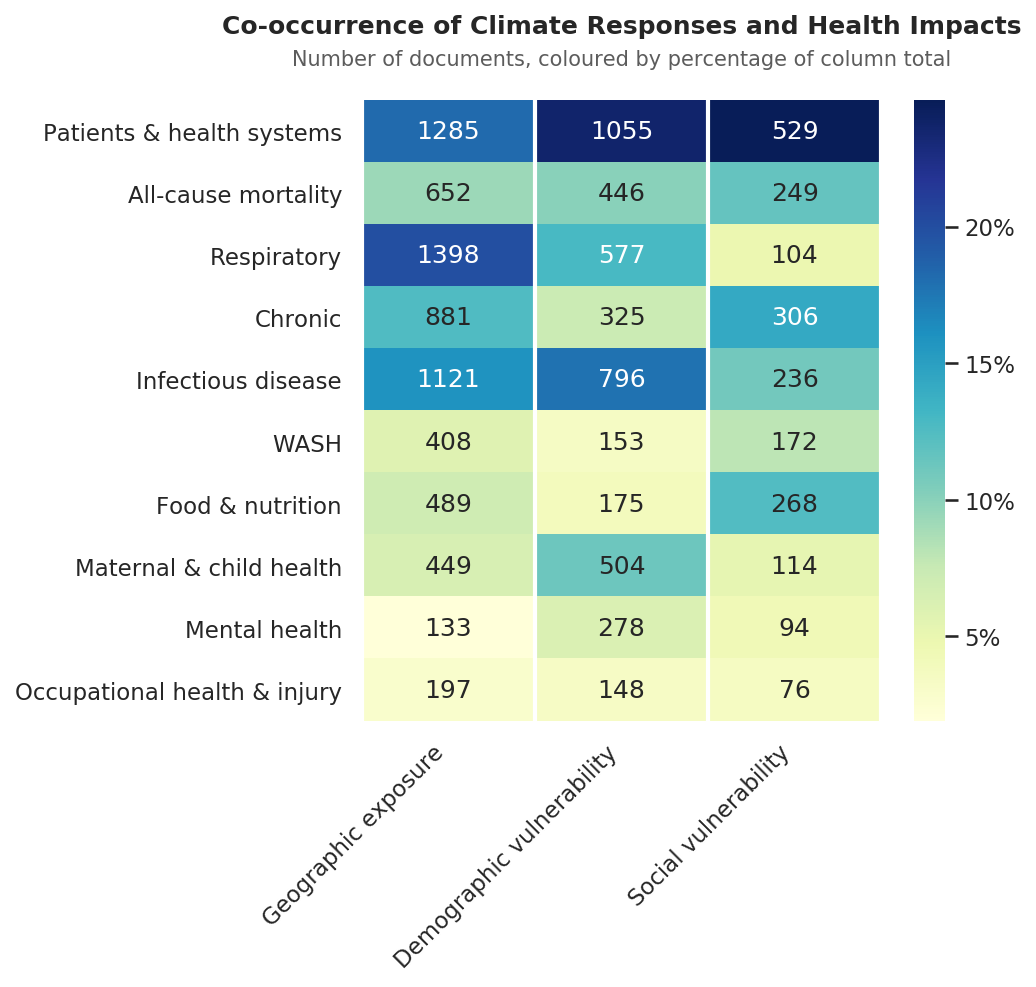

In [43]:
o_cols = (100*o)/o.sum(axis=0, keepdims=True)

#sns.set(font_scale=1)

fig, ax = plt.subplots(figsize = (7,7), dpi=150)

yticks = impacts.columns.to_list()
xticks = mediating.columns.to_list()

sns.heatmap(o_cols, ax=ax, cmap="YlGnBu",annot=o, fmt='d', cbar_kws={'format': '%.0f%%'})

#add horizontal lines
for i in range(o_cols.shape[0]+1):
    ax.axvline(i, color='white', lw=2)
    
#for t in ax.texts: t.set_text(t.get_text() + " %")
#sns.plt.ticklabel_format(style='plain')

ax.set_xticklabels(xticks, rotation=45, ha="right")
ax.set_yticklabels(yticks, rotation=0)

title = 'Co-occurrence of Climate Responses and Health Impacts'
subtitle = "Number of documents, coloured by percentage of column total"
TitleAndSave(fig, ax, title, subtitle)

### Heat map of all/all except those in category

In [119]:
List_all = dts_wide.columns

Im_all_list = [Im_all[n][1] for n in range(len(Im_all))]
Im_all_list = [ inner for outer in Im_all_list for inner in outer]

NotIm = list(set(List_all) - set(Im_all_list))

NotIm_topics = Topic.objects.filter(run_id=run_id,pk__in=NotIm)
Im_topics = Topic.objects.filter(run_id=run_id,pk__in=Im_all_list)

impacts_all = pd.DataFrame()
thresh = 0.015

#NB: given the size of this, I'm flipping the axes (i.e. impacts on x)
m2 = np.zeros((len(Im_topics), len(NotIm_topics)), int)

#Create table with the number of docs above the threshold
for i, it in enumerate(Im_topics): #index, impact topic
    for j, jt in enumerate(NotIm_topics): #index, notImpact topic
        m2[i,j] = dts_wide[
            (dts_wide[it.id]>thresh) &
            (dts_wide[jt.id]>thresh)
        ].shape[0]
       
yticks = [n.title.split(", ")[1] for n in Im_topics]
xticks = [n.title.split(", ")[1] for n in NotIm_topics]

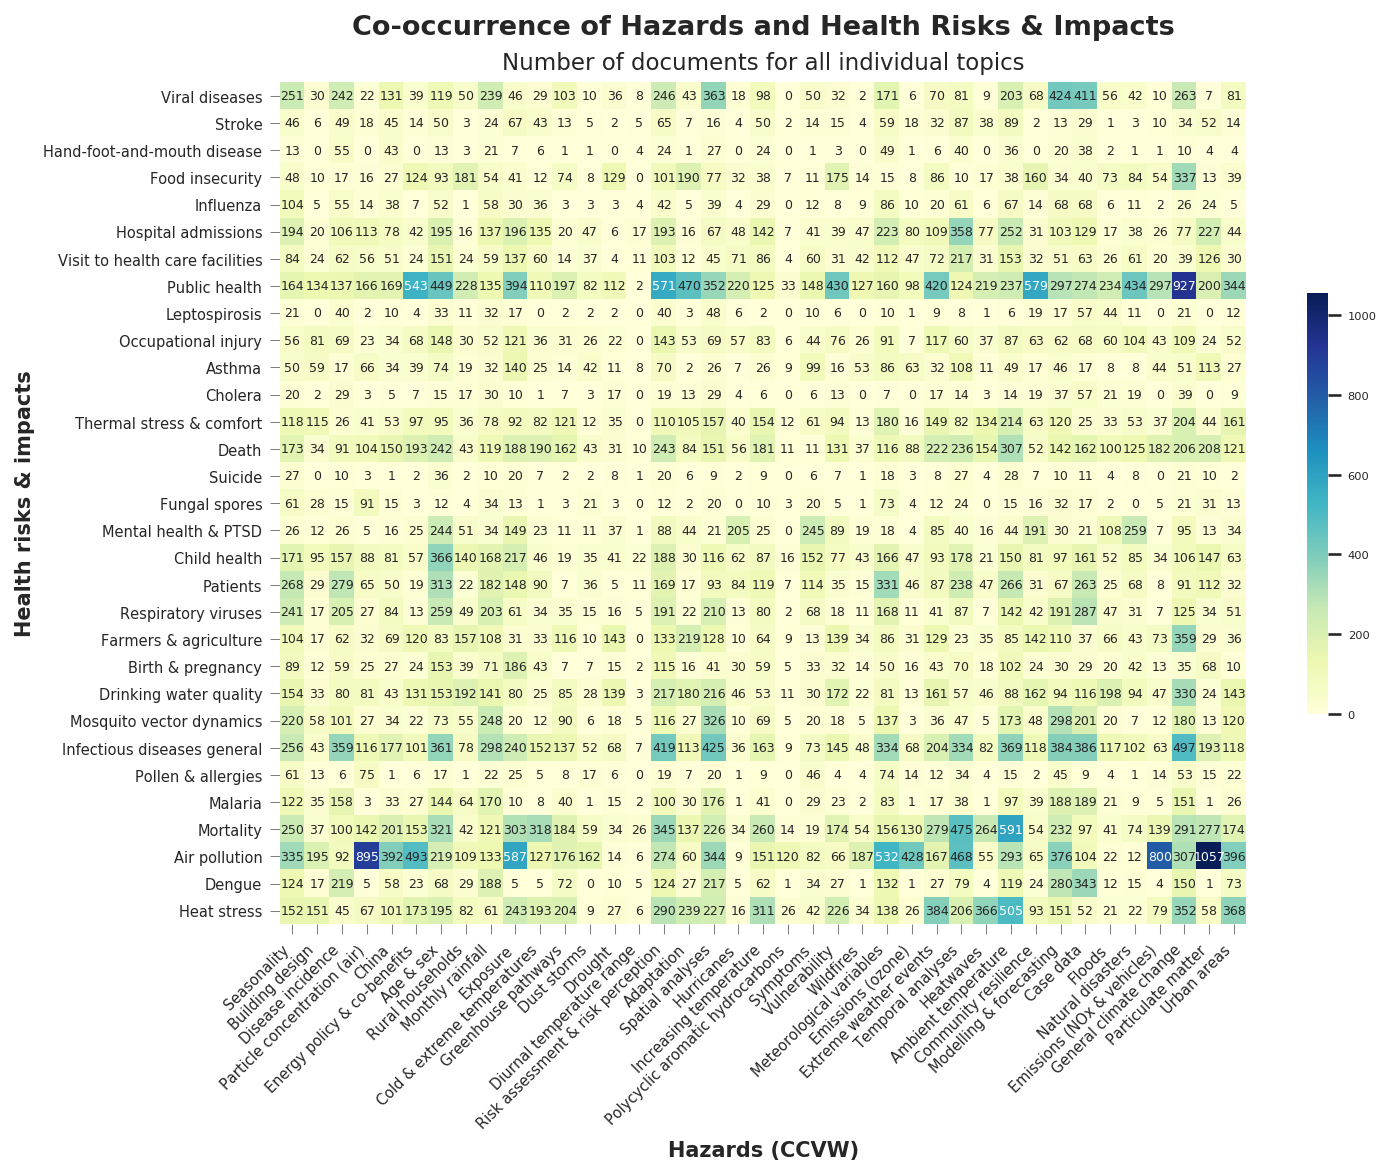

In [118]:
import seaborn as sns
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(10,8),
                       dpi=150)

sns.set(font_scale=0.5)
sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 2})
sns.heatmap(m2, ax=ax, cmap="YlGnBu",annot=True, fmt="d", cbar_kws={"shrink": 0.5})

#ax.set_xticks(np.arange(len(xticks))-.5, length = 4)
#ax.set_yticks(np.arange(len(yticks))-.5, length = 4)
ax.tick_params(axis ='both', which ='both', length = 5, width=0.5, color = "0.5") 
    
ax.set_xticklabels(xticks, rotation=45, ha="right", fontsize=7)
ax.set_yticklabels(yticks, rotation=0, fontsize=7)

plt.xlabel('Hazards (CCVW)', weight = 'bold', fontsize = 10)
plt.ylabel('Health risks & impacts', weight = 'bold', fontsize =10)

title = 'Co-occurrence of Hazards and Health Risks & Impacts'
subtitle = "Number of documents for all individual topics"
#TitleAndSave(fig, ax, title, subtitle)
ax.text(x=0.5, y=1.05, s=title, fontsize=13, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.01, s=subtitle, fontsize=11, ha='center', va='bottom', transform=ax.transAxes)


fig.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(f'heatmap_results/Final/{title}_{subtitle}.png')

In [120]:
#todo: make into DataFrame with x-topics, y-topics
#create lists for axes where topic order is preserved
#Re-order the df to match the order of those lists
#Add labels per agregate topic (? and lines?)
mdf = pd.DataFrame(m2, columns = xticks, index=yticks)
mdf.shape

(31, 39)

In [121]:
#I was doing complicated stuff, but in the end, I think it is easiest to just copy the names from the table
OrderOt = ['Wildfires', 'Dust storms', 'Drought', 'Extreme weather events', 'Floods', 'Hurricanes', 'General climate change', 'Meteorological variables', 'Seasonality', 'Ambient temperature', 'Increasing temperature', 'Heatwaves', 'Cold & extreme temperatures', 'Diurnal temperature range', 'Monthly rainfall', 'Particulate matter', 'Particle concentration (air)', 'Emissions (NOx & vehicles)', 'Emissions (ozone)', 'Polycyclic aromatic hydrocarbons', 'Community resilience', 'Natural disasters', 'Energy policy & co-benefits', 'Greenhouse pathways', 'Adaptation', 'Age & sex', 'Urban areas', 'China', 'Rural households', 'Building design', 'Vulnerability', 'Spatial analyses', 'Modelling & forecasting', 'Risk assessment & risk perception', 'Exposure', 'Case data', 'Temporal analyses', 'Disease incidence', 'Symptoms']
OrderIm = ['Death', 'Mortality', 'Heat stress', 'Thermal stress & comfort', 'Stroke', 'Farmers & agriculture', 'Food insecurity', 'Public health', 'Hospital admissions', 'Patients', 'Visit to health care facilities', 'Infectious diseases general', 'Viral diseases', 'Mosquito vector dynamics', 'Malaria', 'Dengue', 'Influenza', 'Hand-foot-and-mouth disease', 'Leptospirosis', 'Cholera', 'Child health', 'Birth & pregnancy', 'Mental health & PTSD', 'Suicide', 'Occupational injury', 'Air pollution', 'Respiratory viruses', 'Pollen & allergies', 'Asthma', 'Fungal spores', 'Drinking water quality']
#Make sure they match -- change either value on the platform or in list until both return nothing
print(f'Not matching to x:{list(set(xticks)-set(OrderOt))}') 
print(f'Not matching to y:{list(set(yticks)-set(OrderIm))}') 

mdf = mdf.reindex(index = OrderIm, columns=OrderOt)
mdf.head(5)

Not matching to x:[]
Not matching to y:[]


Wildfires  Dust storms  Drought  \
Death                            37           43       31   
Mortality                        54           59       34   
Heat stress                      34            9       27   
Thermal stress & comfort         13           12       35   
Stroke                            4            5        2   

                          Extreme weather events  Floods  Hurricanes  \
Death                                        222     100          56   
Mortality                                    279      41          34   
Heat stress                                  384      21          16   
Thermal stress & comfort                     149      33          40   
Stroke                                        32       1           4   

                          General climate change  Meteorological variables  \
Death                                        206                       116   
Mortality                                    291                       156   
Heat stress                                  352                       138   
Thermal stress & comfort                     204                       180   
Stroke                                        34                        59   

                          Seasonality  Ambient temperature  ...  \
Death                             173                  307  ...   
Mortality                         250                  591  ...   
Heat stress                       152                  505  ...   
Thermal stress & comfort          118                  214  ...   
Stroke                             46                   89  ...   

                          Building design  Vulnerability  Spatial analyses  \
Death                                  34            131               151   
Mortality                              37            174               226   
Heat stress                           151            226               227   
Thermal stress & comfort              115             94               157   
Stroke                                  6             15                16   

                          Modelling & forecasting  \
Death                                         142   
Mortality                                     232   
Heat stress                                   151   
Thermal stress & comfort                      120   
Stroke                                         13   

                          Risk assessment & risk perception  Exposure  \
Death                                                   243       188   
Mortality                                               345       303   
Heat stress                                             290       243   
Thermal stress & comfort                                110        92   
Stroke                                                   65        67   

                          Case data  Temporal analyses  Disease incidence  \
Death                           162                236                 91   
Mortality                        97                475                100   
Heat stress                      52                206                 45   
Thermal stress & comfort         25                 82                 26   
Stroke                           29                 87                 49   

                          Symptoms  
Death                           11  
Mortality                       19  
Heat stress                     42  
Thermal stress & comfort        61  
Stroke                          14  

[5 rows x 39 columns]

In [122]:
mdf_nan = mdf
mdf_nan[mdf_nan == 0] = np.nan

In [137]:
mdf.values.astype(int)

array([[ 37,  43,  31, ..., 236,  91,  11],
       [ 54,  59,  34, ..., 475, 100,  19],
       [ 34,   9,  27, ..., 206,  45,  42],
       ...,
       [ 53,  42,  11, ..., 108,  17,  99],
       [  1,  21,   3, ...,  24,  15,  20],
       [ 22,  28, 139, ...,  57,  80,  30]])

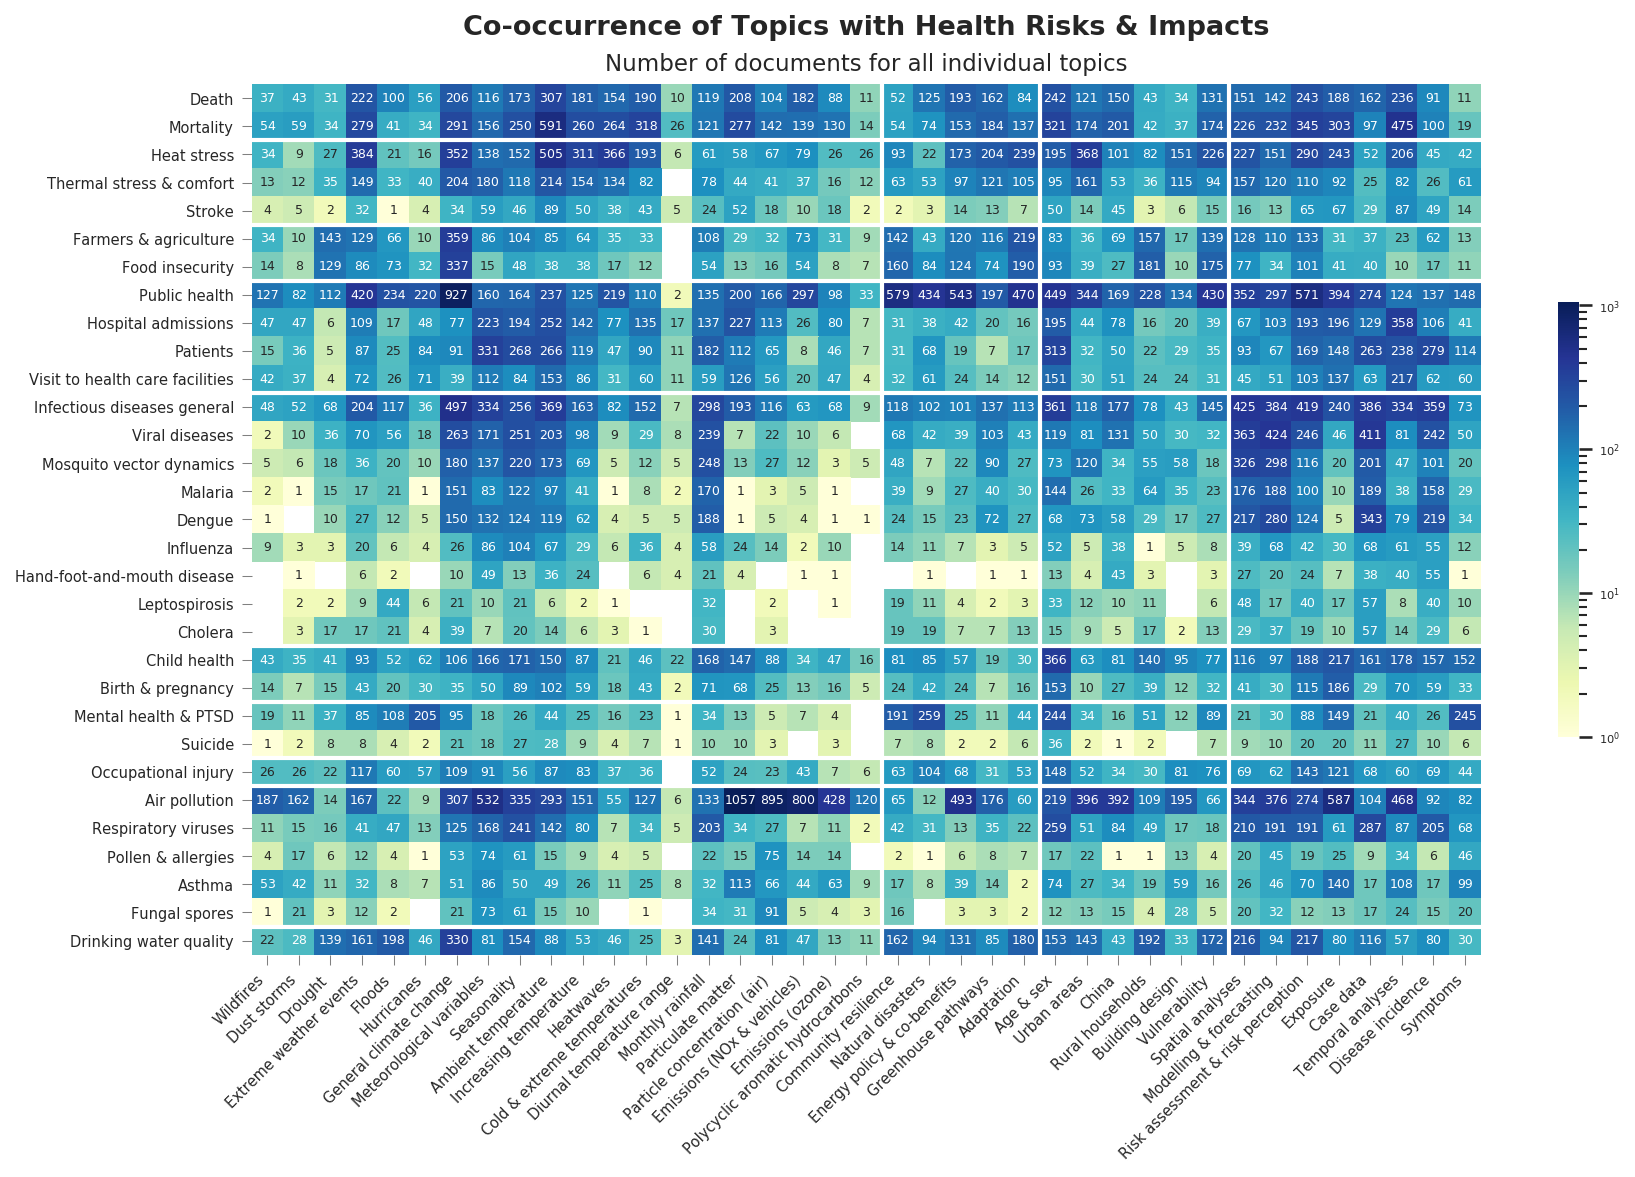

In [158]:
import seaborn as sns
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(12,8),
                       dpi=150)

sns.set(font_scale=0.5)
sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 2})

sns.heatmap(mdf, ax=ax, cmap="YlGnBu",annot=mdf.values.astype(int), fmt="d",
            cbar_kws={"shrink": 0.5},
            norm=LogNorm(vmin=0.01, vmax=mdf.max().max(), clip = True),
           ) #log-normalise, clip=True to prevent log(0)

#ax.set_xticks(np.arange(len(xticks))-.5, length = 4)
#ax.set_yticks(np.arange(len(yticks))-.5, length = 4)
ax.tick_params(axis ='both', which ='both', length = 5, width=0.5, color = "0.5") 

#Draw lines around aggregate topics -- specify positions manually
for i in [20, 25, 31]:
    ax.axvline(i, color='white', lw=2)
for i in [2, 5, 7, 11, 20, 22, 24, 25, 30]:
    ax.axhline(i, color='white', lw=2)
 
ax.set_xticklabels(mdf.columns, rotation=45, ha="right", fontsize=7)
ax.set_yticklabels(mdf.index, rotation=0, fontsize=7)

#plt.xlabel('Hazards (CCVW)', weight = 'bold', fontsize = 10)
#plt.ylabel('Health risks & impacts', weight = 'bold', fontsize =10)


title = 'Co-occurrence of Topics with Health Risks & Impacts'
subtitle = "Number of documents for all individual topics"
#TitleAndSave(fig, ax, title, subtitle)
ax.text(x=0.5, y=1.05, s=title, fontsize=13, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.01, s=subtitle, fontsize=11, ha='center', va='bottom', transform=ax.transAxes)


fig.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(f'heatmap_results/Final/BigHeatmapAll.png')

(31, 20)


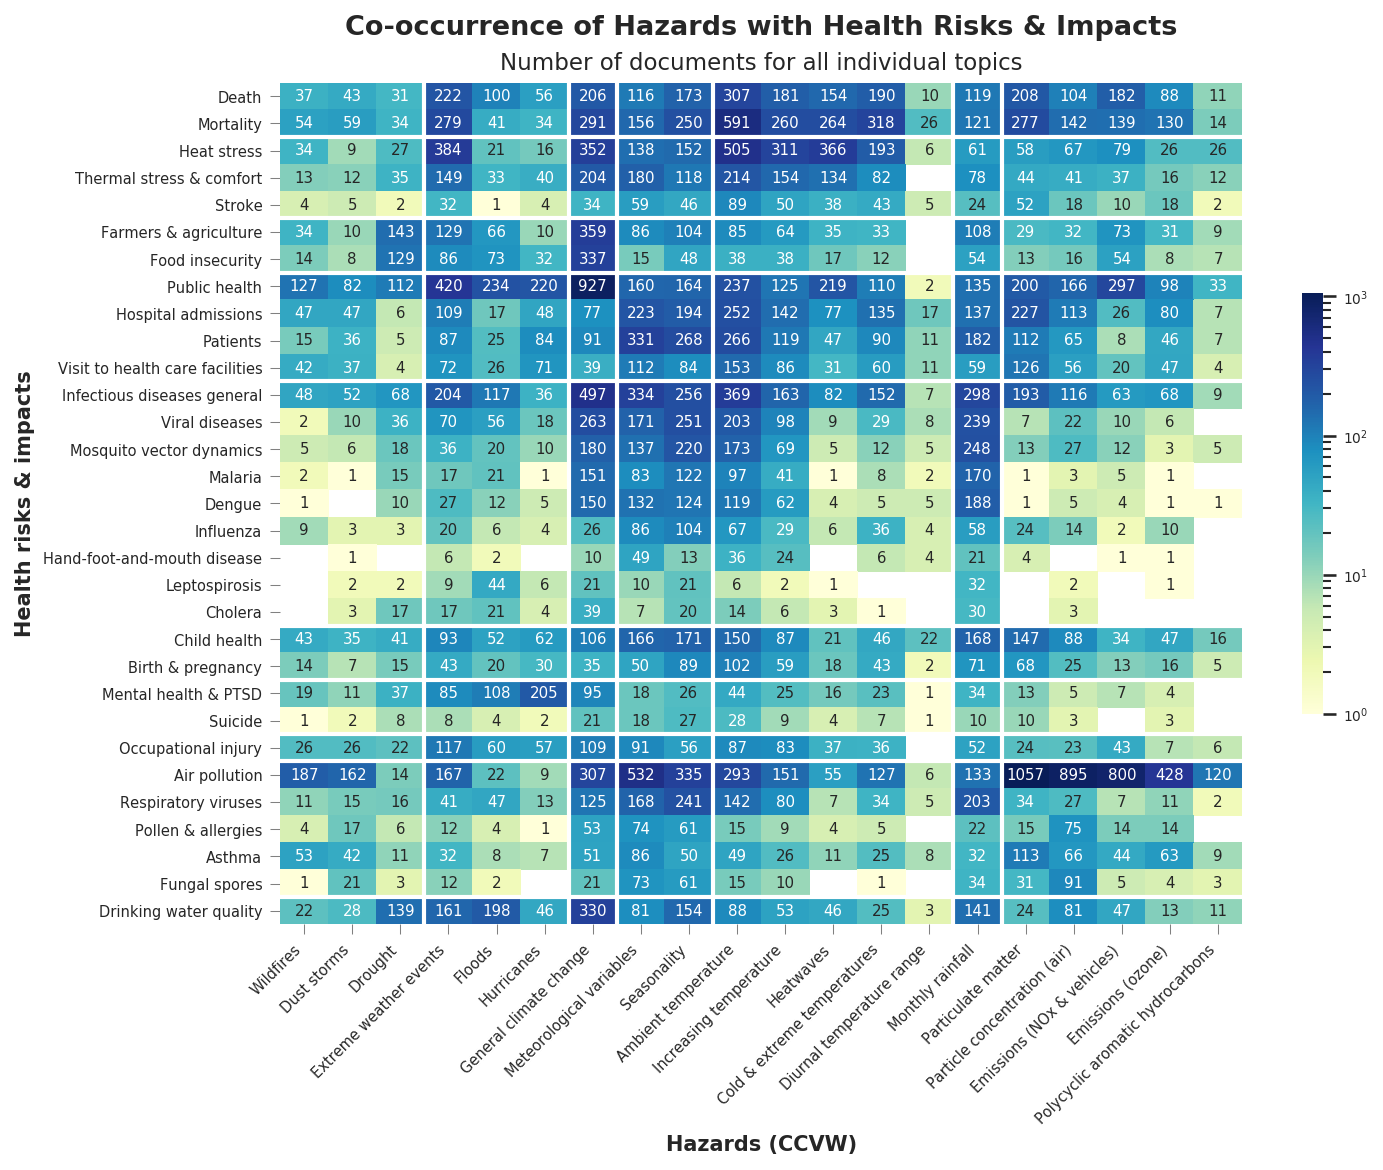

In [187]:
#Same, but now for hazards/drivers only
drdf =mdf[['Wildfires', 'Dust storms', 'Drought', 'Extreme weather events', 'Floods', 'Hurricanes', 'General climate change', 'Meteorological variables', 'Seasonality', 'Ambient temperature', 'Increasing temperature', 'Heatwaves', 'Cold & extreme temperatures', 'Diurnal temperature range', 'Monthly rainfall', 'Particulate matter', 'Particle concentration (air)', 'Emissions (NOx & vehicles)', 'Emissions (ozone)', 'Polycyclic aromatic hydrocarbons']]
print(drdf.shape)

fig, ax = plt.subplots(figsize=(10,8),
                       dpi=150)

sns.set(font_scale=0.6)
sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 2})

sns.heatmap(drdf, ax=ax, cmap="YlGnBu",annot=drdf.values.astype(int), fmt="d",
            cbar_kws={"shrink": 0.5},
            norm=LogNorm(vmin=0.01, vmax=drdf.max().max(), clip = True),
           ) #log-normalise, clip=True to prevent log(0)

#ax.set_xticks(np.arange(len(xticks))-.5, length = 4)
#ax.set_yticks(np.arange(len(yticks))-.5, length = 4)
ax.tick_params(axis ='both', which ='both', length = 5, width=0.5, color = "0.5") 

#Draw lines around aggregate topics -- specify positions manually
for i in [3, 6, 7, 9, 14, 15]:
    ax.axvline(i, color='white', lw=2)
for i in [2, 5, 7, 11, 20, 22, 24, 25, 30]:
    ax.axhline(i, color='white', lw=2)
 
ax.set_xticklabels(drdf.columns, rotation=45, ha="right", fontsize=7)
ax.set_yticklabels(drdf.index, rotation=0, fontsize=7)

plt.xlabel('Hazards (CCVW)', weight = 'bold', fontsize = 10)
plt.ylabel('Health risks & impacts', weight = 'bold', fontsize =10)


title = 'Co-occurrence of Hazards with Health Risks & Impacts'
subtitle = "Number of documents for all individual topics"
#TitleAndSave(fig, ax, title, subtitle)
ax.text(x=0.5, y=1.05, s=title, fontsize=13, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.01, s=subtitle, fontsize=11, ha='center', va='bottom', transform=ax.transAxes)


fig.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(f'heatmap_results/Final/BigHeatmapHazards.png')

(31, 5)


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


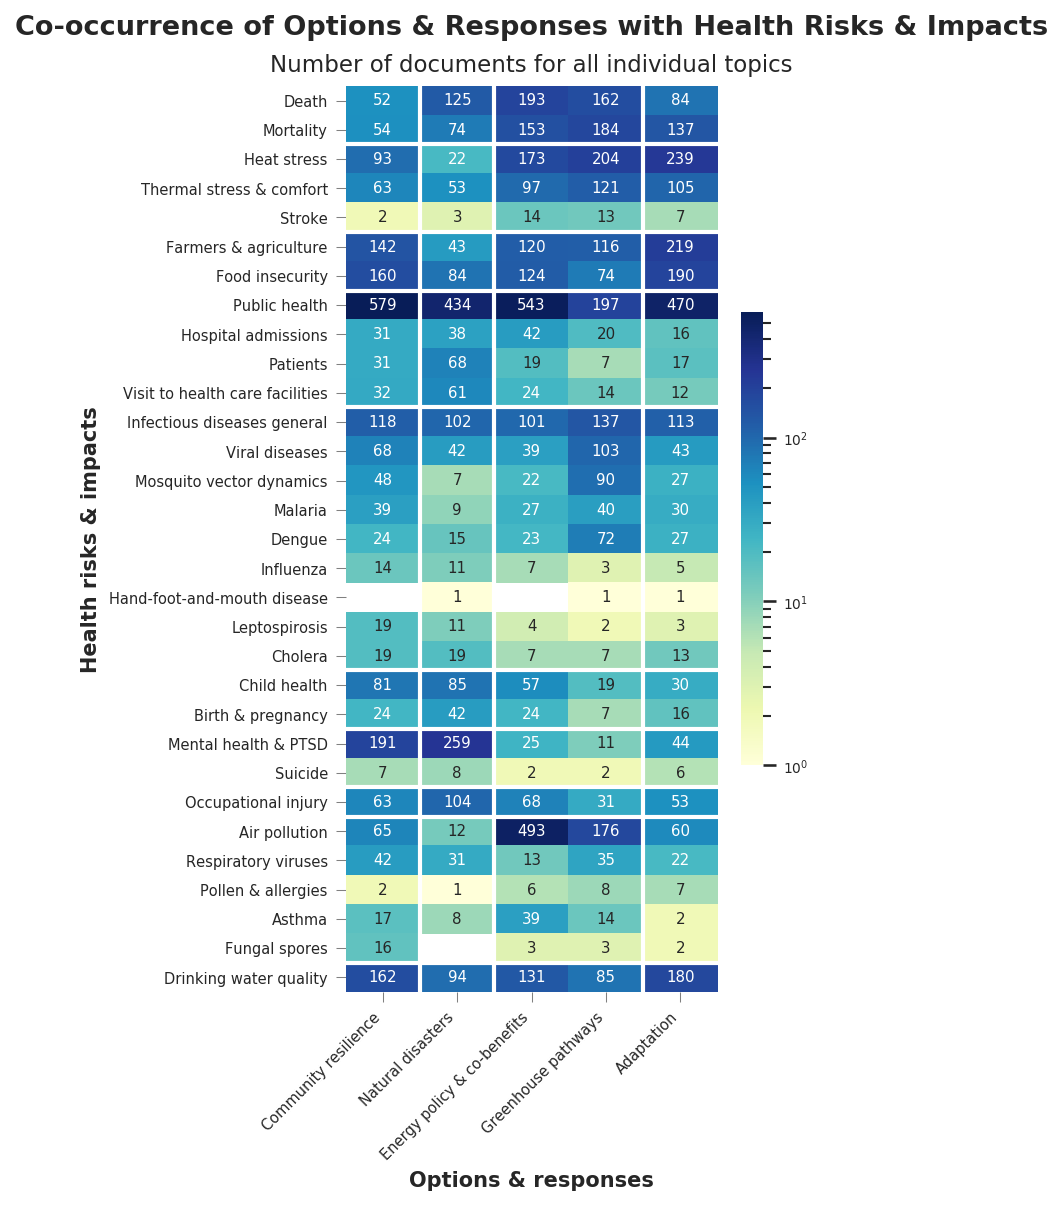

In [188]:
#Same, but now for responses only
redf =mdf[['Community resilience', 'Natural disasters', 'Energy policy & co-benefits', 'Greenhouse pathways', 'Adaptation']]
print(redf.shape)

fig, ax = plt.subplots(figsize=(4,8),
                       dpi=150)

sns.set(font_scale=0.6)
sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 2})

sns.heatmap(redf, ax=ax, cmap="YlGnBu",annot=redf.values.astype(int), fmt="d",
            cbar_kws={"shrink": 0.5},
            norm=LogNorm(vmin=0.01, vmax=redf.max().max(), clip = True),
           ) #log-normalise, clip=True to prevent log(0)

#ax.set_xticks(np.arange(len(xticks))-.5, length = 4)
#ax.set_yticks(np.arange(len(yticks))-.5, length = 4)
ax.tick_params(axis ='both', which ='both', length = 5, width=0.5, color = "0.5") 

#Draw lines around aggregate topics -- specify positions manually
for i in [1, 2, 4]:
    ax.axvline(i, color='white', lw=2)
for i in [2, 5, 7, 11, 20, 22, 24, 25, 30]:
    ax.axhline(i, color='white', lw=2)
 
ax.set_xticklabels(redf.columns, rotation=45, ha="right", fontsize=7)
ax.set_yticklabels(redf.index, rotation=0, fontsize=7)

plt.xlabel('Options & responses', weight = 'bold', fontsize = 10)
plt.ylabel('Health risks & impacts', weight = 'bold', fontsize =10)


title = 'Co-occurrence of Options & Responses with Health Risks & Impacts'
subtitle = "Number of documents for all individual topics"
#TitleAndSave(fig, ax, title, subtitle)
ax.text(x=0.5, y=1.05, s=title, fontsize=13, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.01, s=subtitle, fontsize=11, ha='center', va='bottom', transform=ax.transAxes)


fig.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(f'heatmap_results/Final/BigHeatmapOptions.png')

(31, 31)


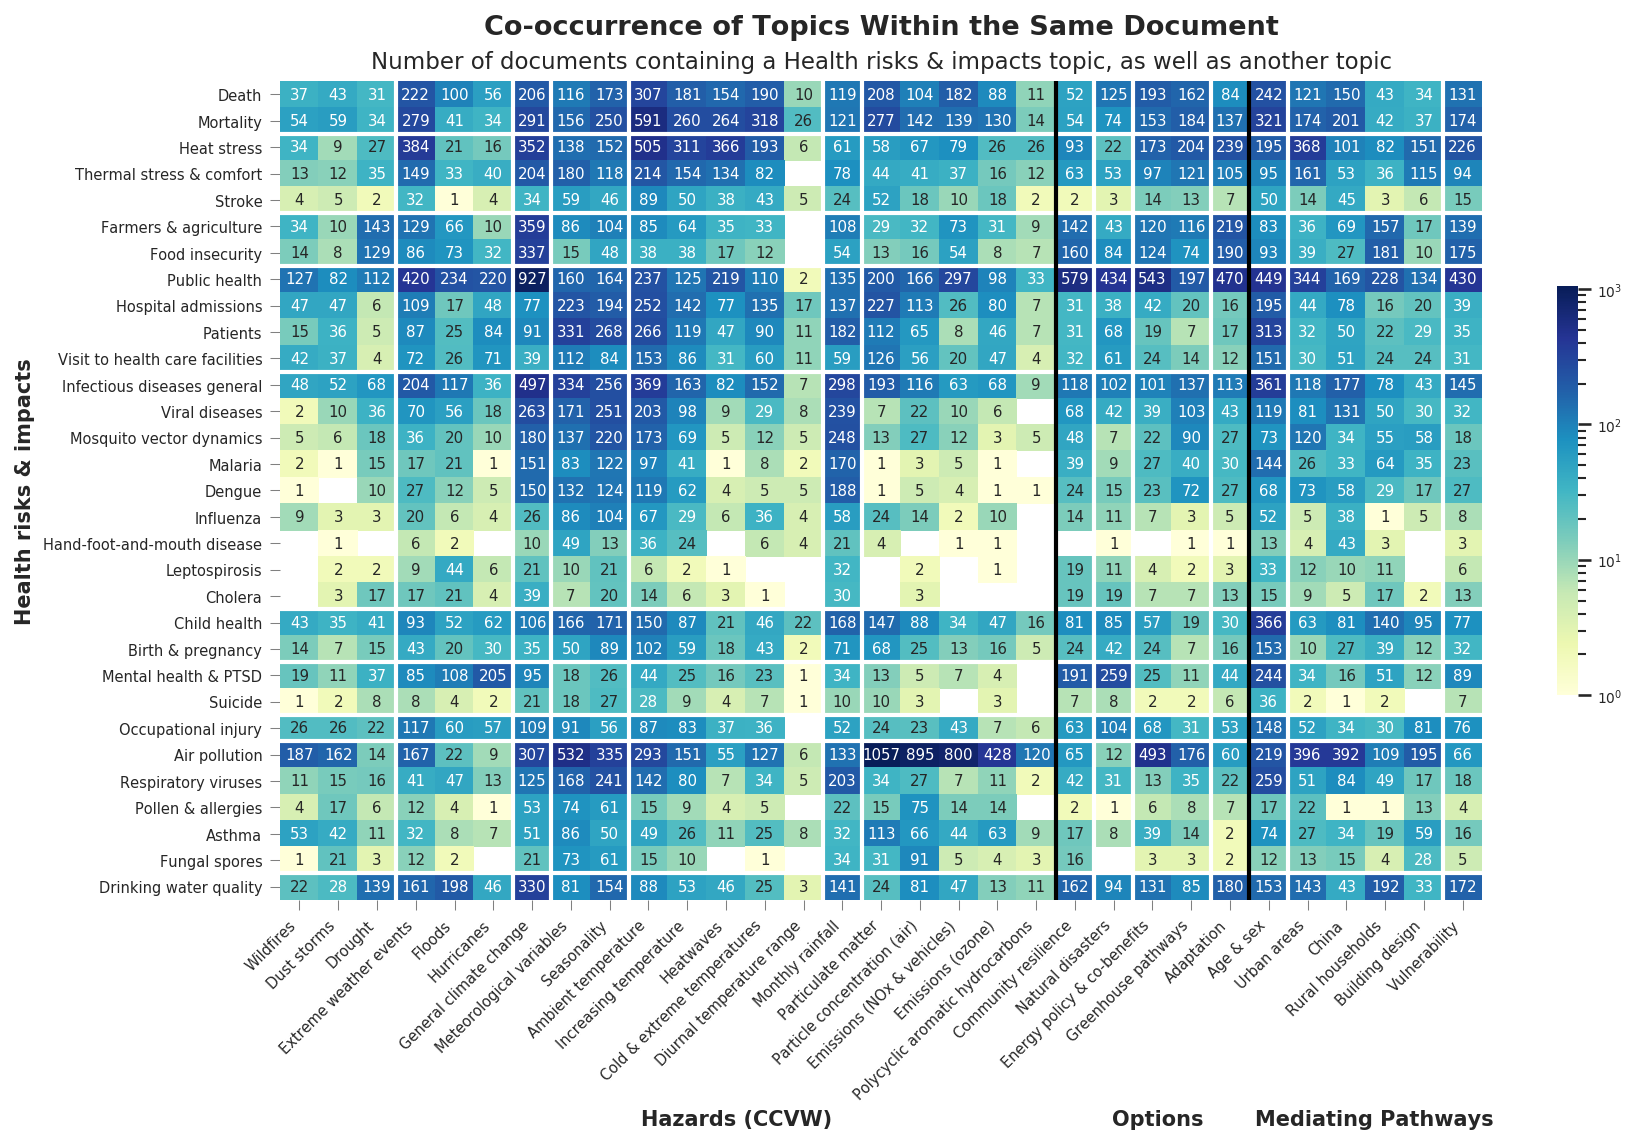

In [201]:
#Responses and hazards
comdf =mdf[['Wildfires', 'Dust storms', 'Drought', 'Extreme weather events', 'Floods', 'Hurricanes', 'General climate change', 'Meteorological variables', 'Seasonality', 'Ambient temperature', 'Increasing temperature', 'Heatwaves', 'Cold & extreme temperatures', 'Diurnal temperature range', 'Monthly rainfall', 'Particulate matter', 'Particle concentration (air)', 'Emissions (NOx & vehicles)', 'Emissions (ozone)', 'Polycyclic aromatic hydrocarbons','Community resilience', 'Natural disasters', 'Energy policy & co-benefits', 'Greenhouse pathways', 'Adaptation', 'Age & sex', 'Urban areas', 'China', 'Rural households', 'Building design', 'Vulnerability']]
print(comdf.shape)

fig, ax = plt.subplots(figsize=(12,8),
                       dpi=150)

sns.set(font_scale=0.6)
sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 2})

sns.heatmap(comdf, ax=ax, cmap="YlGnBu",annot=comdf.values.astype(int), fmt="d",
            cbar_kws={"shrink": 0.5},
            norm=LogNorm(vmin=0.01, vmax=comdf.max().max(), clip = True),
           ) #log-normalise, clip=True to prevent log(0)

#ax.set_xticks(np.arange(len(xticks))-.5, length = 4)
#ax.set_yticks(np.arange(len(yticks))-.5, length = 4)
ax.tick_params(axis ='both', which ='both', length = 5, width=0.5, color = "0.5") 

#Draw lines around aggregate topics -- specify positions manually
for i in [2, 5, 7, 11, 20, 22, 24, 25, 30]:
    ax.axhline(i, color='white', lw=2)
for i in [3, 6, 7, 9, 14, 15, 21, 22, 24, 26, 30]:
    ax.axvline(i, color='white', lw=2)
for i in [20, 25]:
    ax.axvline(i, color='black', lw=2) #separating the aggregate topics
 
ax.set_xticklabels(comdf.columns, rotation=45, ha="right", fontsize=7)
ax.set_yticklabels(comdf.index, rotation=0, fontsize=7)

#plt.xlabel('Options & responses', weight = 'bold', fontsize = 10)
plt.ylabel('Health risks & impacts', weight = 'bold', fontsize =10)
#Adding texts for the aggregate topics on the x-axis
ax.text(x=0.38, y=-0.28, s='Hazards (CCVW)', fontsize=10, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.73, y=-0.28, s='Options', fontsize=10, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.91, y=-0.28, s='Mediating Pathways', fontsize=10, weight='bold', ha='center', va='bottom', transform=ax.transAxes)

title = 'Co-occurrence of Topics Within the Same Document'
subtitle = "Number of documents containing a Health risks & impacts topic, as well as another topic"
#TitleAndSave(fig, ax, title, subtitle)
ax.text(x=0.5, y=1.05, s=title, fontsize=13, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.01, s=subtitle, fontsize=11, ha='center', va='bottom', transform=ax.transAxes)


fig.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(f'heatmap_results/Final/BigHeatmapHazardsAndOptions.png')

In [47]:
!tar czf myfiles.tar.gz *.png